# Inscriptions as data: digital epigraphy in macro-historical perspective 

### Petra Hermankova
Corresponding Author. Aarhus University, [ORCID: 0000-0002-6349-0540](https://orcid.org/0000-0002-6349-0540)

### Vojtech Kase
Author. Aarhus University, [ORCID: 0000-0002-6601-1605](http://orcid.org/0000-0002-6601-1605)

### Adela Sobotkova
Author. Aarhus University, [ORCID:0000-0002-4541-3963](https://orcid.org/0000-0002-4541-3963)

**Abstract**

Inscriptions, as short texts written on a permanent medium, represent invaluable historical evidence of past societies, their organisation, cultural norms and practices, demographic patterns and human past behaviour. Several hundred thousand inscriptions in Greek and Latin language survived until today, providing us with a direct line of evidence to populations of large cities but also of rural communities of the entire Mediterranean Basin in the period between the 8th c. BC and 8th c. AD. Despite the enormous historical potential of inscriptions, large-scale and comparative studies are still rare, even though we live in the age of ample digital tools and online databases. The aim of this article is to demonstrate some of the challenges of macro-scale digital history on the example of online epigraphic resources. We have developed a FAIR and open science pipeline to overcome some of the challenges and biases that are not limited to inscriptions, but are inherent to any historical evidence. Amongst others, we discuss the computational approaches to problematic and incomplete datasets, temporal or spatial uncertainty of historical evidence and assess the suitability of traditional vs proposed solutions for historical research. 
	In the current article, we target primarily the first stages of the research lifecycle, such as data-access and streamlining phase as a key and formative aspect of any historical analysis, that is however often made peripheral in favour of analysis and discussion of results. We document the full research lifecycle of work with digital historical datasets in a series of scripts in R and Python, with primary focus on transparency and reproducibility in order to promote scientific collaboration and advance the historical discipline.
We demonstrate our approach on two well-established digital sources for Latin epigraphy, both posing different challenges to any quantitative researcher: Epigraphic Database Heidelberg (EDH) containing over 81,000 of records and Epigraphische Datenbank Clauss-Slaby (EDCS) with 500,000 records.



**Keywords**

digital epigraphy; quantitative research; FAIR science; reproducibility; digital history

**GitHub**

https://github.com/sdam-au/digital_epigraphy

**Data Source**

EDH dataset: https://sciencedata.dk/public/b6b6afdb969d378b70929e86e58ad975/EDH_text_cleaned_2021-01-21.json

EDCS dataset: https://sciencedata.dk/public/1f5f56d09903fe259c0906add8b3a55e/EDCS_text_cleaned_2021-03-01.json

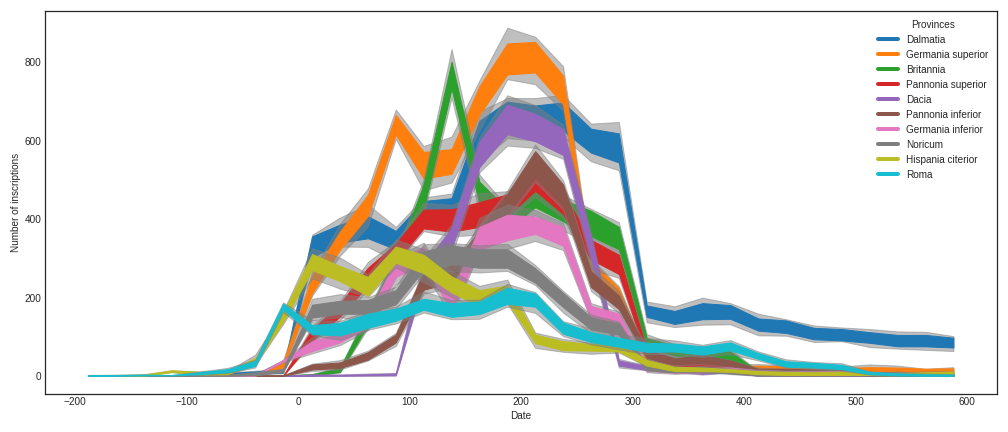

In [129]:
from IPython.display import Image, display
metadata = {
    "jdh": {
        "module": "object",
        "object": {
            "type": "image",
            "source": [
                "figure caption.",
                "copyright 2020"
            ]
        }
    }
}
display(Image("Epigraphic_production_provinces_EDH.png"),
        metadata=metadata)  # test the placeholder cover image

**Notebook Configuration**

In [20]:
# Python configurations
!pip install matplotlib >= 3.4 sddk tempun scipy seaborn nltk rpy2 cite2c geopandas

#!pip install -r requirements.txt (eventually we can load reqs via requirements)

In [21]:
import geopandas as gpd
import cite2c
import requests
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from scipy.stats import trapz
import scipy
import nltk
import json
import tempun
import sddk
import numpy as np
import pandas as pd
pd.options.display.max_columns = 1000  # to see all columns

In [3]:
%load_ext rpy2.ipython

/opt/conda/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [117]:
% % R
# installing R requirements

install.packages(c("jsonlite", "tidyverse"),
                 repos='https://mirrors.dotsrc.org/cran/')
devtools: : install_github("sdam-au/sdam")
# if(!require(devtools)) install.packages("devtools")
# devtools::install_github("kassambara/ggpubr") # works only in R higher than v3.6

options(warn=-1)  # supress all warning messages

R[write to console]: Installing packages into ‘/usr/local/spark-3.0.0-bin-hadoop3.2/R/lib’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://mirrors.dotsrc.org/cran/src/contrib/jsonlite_1.7.2.tar.gz'

R[write to console]: Content type 'application/octet-stream'
R[write to console]:  length 421716 bytes (411 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R

In [118]:
% % R
library(tidyverse)
library(sdam)
library(jsonlite)
# library(ggpubr)

## Introduction
Inscriptions represent a diverse yet comparable source for the long-term studies of the ancient Mediterranean communities, including the evolution of demographic trends, migration patterns, changes of the socio-political organisation and cultural development. Estimates suggest over 600,000 Greek and Latin inscriptions have survived until today, but the overall number can be even higher as new inscriptions are published every year (Beltran-Lloris 2014, 135). Inscriptions vary greatly in form and contents, touching almost all aspects of life in an ancient society. The diverse group of texts range from short private messages on objects of daily use to extensive regulations and laws issued by a political authority, or to monumental inscriptions creating a public image and prestige. In contrast with literary texts that were often preserved via the act of multiple copying, the text of inscription has the original unaltered form with original typographical and grammatical errors. Moreover, the information preserved via inscriptions has wider demographic coverage than literary texts as inscriptions were produced by various social groups of diverse background and do not represent only the elite’s point of view. Thus, the diversity of epigraphic sources and their large number make inscriptions an ideal source for macro-historical studies of ancient society.
  
One of the main questions epigraphers have been asking for decades is the one of varying levels of epigraphic production in time and space and the underlying reasons for such change in human behaviour. The so-called 'epigraphic habit' in the Roman Empire has been puzzling researchers for over 40 years, both in Greek and Roman epigraphic world (MacMullen 1982; Meyer 1991; Woolf XXX; ... Beltran Lloris 2014, Nawotka 2020). The majority agrees, there is a combination of reasons behind the decision of an individual or a social group leading to a creation of an inscription. But before we can come up with a more nuanced answer to what were the main motivations of epigraphic production and why they were more prevalent in certain times or areas, we need to be able to locate inscriptions in place, and most importantly in time. The temporal classification of inscriptions, however, contains a lot of uncertainty, making the comparative study complex and dependent on computational solutions. 
 
A small fraction of inscriptions can be dated to a particular year, usually by their textual reference to a known calendar, event or historical person (McLean 2003, XXX). When interpreted and published, most inscriptions are assigned an interval between the two points in time, terminus post quem and terminus ante quem. Thus, their date is represented by a temporal interval, rather than a precise and unique date. Some of the intervals might be very broad, spanning across several centuries. While it is reasonable to plot inscriptions dated to individual years on a temporal axis, the same method cannot be applied to inscriptions with a wide dating interval in order to produce meaningful outputs. 

In recent years, large digital corpora containing tens of thousands inscriptions were made accessible to any researcher and published online and yet they remain underutilised as resources for quantitative and comparative studies (Elliott 2014, 80-83). Although the analysis of a large body of inscriptions may seem relatively straightforward from an outsider’s point of view, one has to deal with numerous technological, methodological and even ethical challenges when accessing digital datasets. We will address some of the challenges of large scale comparative research in the digital age on examples of two well established digital resources: 
 
* [Epigraphic Database Heidelberg](https://edh-www.adw.uni-heidelberg.de/) (EDH) represents a flagship resource for Latin epigraphers and pioneer in the open and FAIR epigraphy with over 30 years of development; 
 
* [Epigraphic Database Clauss-Slaby](http://www.manfredclauss.de/) (EDCS) is the most extensive digital resource for Latin inscriptions, with over 500,000 texts. The overwhelming size of the EDCS unfortunately goes hand in hand with several shortcomings and well known limitations of the dataset, which we address accordingly.

Using the two digital epigraphic sources, we demonstrate a computational solution to temporal uncertainty of historic data in comparative and longitudinal studies. The current article does not aim to address all the aspects of the epigraphic habit per se, but rather to pave the path to digital and quantitative research in epigraphy.
    
In accordance with the Open and FAIR science practice, we advocate for transparency during the full research lifecycle, including its preliminary data-collection and access stages. We believe the only way forward for any digital researcher is to document all methodological decisions leading to modifications to the dataset alongside with the raw data and to do so in an open and accessible manner. Thus, all the stages of our project are accessible via public repositories on GitHub and Zenodo under CC-BY-SA 4.0 International license. Should anyone wish to build upon our work, or use the tools or methods we have developed, the provided license clearly states the conditions and thus facilitates the collaborative and inclusive research environment.


## Data sources

We have chosen two well established digital sources for Latin inscriptions, [Epigraphic Database Heidelberg](https://edh-www.adw.uni-heidelberg.de/) and [Epigraphic Database Clauss-Slaby](http://www.manfredclauss.de/) in order to demonstrate the range of challenges a digital historian has to face when doing comparative historical research. We shortly present both sources and contrast their contents in relation to available spatial and chronological metadata and the epigraphic texts, all crucial aspects of quantitative analysis inscriptions over space and time.

### Epigraphic Database Heidelberg 

The Epigraphic Database Heidelberg ([EDH](https://edh-www.adw.uni-heidelberg.de/)) represents the flagship digital resource for the discipline of digital epigraphy with over 30 years of development and high quality of its outputs. Thus, the EDH dataset with more than 81,000 inscriptions provides a representative sample of the total body of inscriptions from the Mediterranean dating from the 6th century BC to the 9th century AD covering most of the area of the former Roman Empire.

#### Contents of EDH
EDH is one of the pioneers of digital and open epigraphy, providing access to high standard digital resources. The original [aim of the project](https://edh-www.adw.uni-heidelberg.de/projekt/konzept) financed by the Heidelberg Academy of Sciences And Humanities is to *“to render the epigraphic documentation of the provinces of the Roman Empire as completely and reliably as possible for online research work”* . Under the principles of FAIR data, the entire EDH Open Data Repository can be reused under the CC BY-SA 4.0 [licence](https://edh-www.adw.uni-heidelberg.de/data), making an ideal candidate for quantitative research on epigraphic cultures of the Mediterranean. The data is accessible via public API ([Application Programming Interface](https://edh-www.adw.uni-heidelberg.de/data/api)) and its editors are responsible for the quality of data entry as noted directly in individual XML files. Alternatively, the data can be accessed in raw Epidoc XML files, either directly on the website, GitHub pages or through Zenodo archive. However, based on the personal communication in 2020 with the maintainer of the EDH digital archive Frank Grieshaber, the API contains the most updated version of the data and will do so until the end of 2021. The accessibility of the future of the dataset beyond 2022 will be ensured by the release of the data-archives on Zenodo and on GitHub. As of March 2021, the phase of active data-entry is planned to finish in December 2021 with the end support by the Heidelberg Academy of Sciences.  

The EDH API provides direct access to the latest data, containing 11 attributes providing spatial and temporal metadata, object metadata, as well as the text of an inscription, its typological categorisation, bibliographical references and links to related digital sources and photos. Geospatial data are stored separately in the Geo API, as well as bulk dump with individual XML files containing additional metadata not present in the EDH API. In June 2019 the authors claimed the database contained over 1.4 million metadata fields, averaging 18 metadata fields per inscription (Grieshaber 2019). As of September 2020, the EDH contained over 81,476 inscriptions, almost 40,000 photographs, 30,000+ locations and over 16,000 bibliographical publications.

We have accessed the data on 22 September 2020 through the APIs and the XML dumps available via the project’s website and extracted a dataset containing 81,476 inscriptions in total. After initial streamlining and cleaning of our dataset contains data from all the tree sources in 74 attributes, a dataset set which we use to demonstrate our approach. We will discuss the entire access and preprocessing of the dataset and the technological solutions in the methodological section.

In [ ]:
% % R
# Loading the EDH dataset from public folder on Sciencedata.dk using sddk R package

resp = sdam:: request("EDH_text_cleaned_2021-01-21.json", path="public/b6b6afdb969d378b70929e86e58ad975/", method="GET", anonymous = TRUE)
list_json < - jsonlite: : fromJSON(resp)
EDH = as_tibble(list_json)
head(EDH, 3)

#### Language of inscriptions in EDH
The vast majority of the 81,476 inscriptions recorded in the EDH database is written in Latin (97.57 % of all inscriptions). Greek inscriptions represent 1.58 %, combined Greek-Latin inscriptions 0.81 % and the rest consisting of other Mediterranean languages such as Phoenician, Punic, Celtic, Hebrew, Iberian, Italic, Numidian or Palmyrenic and their combination with mostly Latin. Therefore, the EDH dataset predominantly represents epigraphic cultures publishing in Latin, rather than all epigraphic languages of the Mediterranean. We have to bear in mind, the EDH dataset does not provide a representative sample for Greek writing cultures of the Roman East, although the EDH dataset covers the also Latin inscriptions from the Eastern Mediterranean.

In [ ]:
% % R
# How many languages are represented in EDH

lang_EDH < - as.data.frame(table(EDH$language))
lang_EDH < - lang_EDH % >%
rename(Language=Var1) % >%
mutate(Percentage=Freq/(nrow(EDH)/100)) % >%
arrange(-Percentage)
lang_EDH$Percent_round < - round(lang_EDH$Percentage, digits=2)

head(lang_EDH, 3)

#### Spatial information in EDH
EDH stores spatial information related to the findspot of an inscription in the form of text and also as a geospatial coordinates. The EDH creators extracted the findspot information from the original publication (editio princeps), that varied in detail provided, and subsequently transformed it into a digital form. The textual description of the findspot can be broken into several categories, such as the name of ancient settlement, Roman Province, modern country, region of modern place name, or alternatively place of the present location of the inscription. 

The inscriptions in the EDH come from 54 modern countries, and from 65 Roman provinces. However, we have to bear in mind that EDH does not systematically record inscriptions from Rome, as it primarilly focuses on colecting data from Roman Provinces. There are numerous other databases focusing on collection of epigraphic datasets from Rome, such as [Epigraphic Database Roma](http://www.edr-edr.it/en/present_en.php) (EDR), or subsequnetly EDCS that draws data from EDR. According to EDR, there are more than 34,000 inscriptions from Rome, but EDH as such records only 4393 inscriptions from province `Rome`.

EDH provides textual description of an ancient findspot in 83.5 % of inscriptions. The attribute `findspot_ancient` before cleaning contains 3613 unique text strings, including notations of uncertainty or textual indicators of spatial fuzziness. By extracting the textual indicators of uncertainty during the cleaning process we were able to  narrow down the total number of unique ancient findspots to 2342, for details see [link to hermeneutics]. However is the textual name of a ancient findspot important for socio-historical studies, qunatified approaches call for geospatial coordinates. 

The numeric geospatial coordinates denote an exact location on the surface of the Earth, making them an ideal candidate for quantified analysis. Their numeric format provides a computationally accessible means of placing the findspot on a map. Then we can relatively easily explore any occurring spatial patterns, such as their clustering in the proximity of large settlements or roads, commercial hubs or religious sanctuaries. Of the total 81,476 inscriptions in the EDH, the 97 % has assigned geospatial coordinates that enable us to place them on a map, while 2,464 inscriptions have missing geospatial coordinates (3 % of all inscriptions).

In [41]:
% % R

###### Consider


location_EDH < - EDH % >%
select(id, coordinates, findspot_ancient, findspot_ancient_clean, findspot_ancient_certainty, province_label, province_label_clean, province_label_certainty, country, country_clean, country_certainty, modern_region,
       modern_region_clean, modern_region_certainty, findspot_modern, findspot_modern_clean, findspot_modern_certainty, findspot, findspot_clean, findspot_certainty, present_location, edh_geography_uri, commentary)

# number of unique findspots before cleaning
length(unique(location_EDH$findspot_ancient))

# number of unique findspots after cleaning
length(unique(location_EDH$findspot_ancient_clean))

# how many % of inscriptions have a known findspot
nrow(filter(location_EDH, findspot_ancient_clean != "NULL"))/(nrow(EDH)/100)

# from how many modern countries come inscriptions
length(unique(location_EDH$country_clean))

# from how many Roman provinces come inscriptions
length(unique(location_EDH$province_label_clean))

# how many inscriptions come from Roma
nrow(filter(location_EDH, province_label_clean == "Roma"))

SyntaxError: invalid syntax (<ipython-input-41-4dbfa45234fa>, line 2)

In [11]:
% % R

# Consider



# how many inscriptions have spatial coordinates available
nrow(EDH)-sum(str_count(location_EDH$coordinates, "list()"))

# how many % of inscriptions have spatial coordinates available
(nrow(EDH)-sum(str_count(location_EDH$coordinates, "list()")))/(nrow(EDH)/100)

[1] 96.9758


In [12]:
% % R


# Consider moving to external script

# Function to count decimal places

decimalplaces < - function(x) {
    x_str < - toString(x)
    x_str < - str_split(x_str, "\\.")
    nchar(x_str[[1]][2])
}

In [43]:
% % R

# Consider moving to external script

# Number of decimal places in coordinates
location_EDH < - location_EDH % >%
separate(col=coordinates, into=c("latitude", "longitude"), sep=",", remove=FALSE) % >%
mutate(latitude=as.numeric(str_extract(latitude, "[-]*\\d{1,2}\\.\\d+"))) % >%
mutate(longitude=as.numeric(str_extract(longitude, "[-]*\\d{1,2}\\.\\d+")))

loc_prec_EDH < - location_EDH % >%
select(latitude, longitude) % >%
mutate(latitude_decim=map(location_EDH$latitude, decimalplaces)) % >%
mutate(longitude_decim=map(location_EDH$longitude, decimalplaces))

loc_prec_EDH % >%
filter(!is .na(latitude_decim) & !is.na(longitude_decim)) % >%
count(latitude_decim, longitude_decim, sort=T) % >%
mutate(percent=n/(sum(n)/100)) % >%
mutate(percent=round(percent, 2)) % >%
head()

SyntaxError: invalid syntax (<ipython-input-43-8cfbf057ce75>, line 6)

#### Chronological information in EDH
Chronological information is in the EDH database distributed across six attributes, either as textual or numeric values representing the most probable date of an inscription. The date is stored as an interval between the two points in time, represented by attributes `not before` and `not after`. 

The `not_before` attribute represents the earliest possible year when the inscription was created. The `not_before` attribute is available for 59,788 (73.38 % of all) inscriptions in the EDH, ranging from 530 BC to AD 901 (excluding the dates from 19th and 20th century AD). The `not_after` attribute stands for the latest possible year when the inscription was created. The `not_after` attribute is available for 56,281 (69.08 % of all) inscriptions, covering the time range from 503 BC to 950 AD, excluding the 16th and 20th century outliers. For computational reasons and the ease of use, all the dates in Epidoc XML and in the EDH API have been simplified into the four digits, representing a year, e.g. `-0143` stands for 143 BC, `0036` stands for AD 36. Both numeric attributes are present in 56,281 inscriptions (69.08 % of all), with the average length of the interval between the two dates as 120.5 years. 

For most of the texts, the EDH API nor the raw XML files provide any additional information on how precise the date is or which dating method was used to determine the exact date. The original Epidoc XML files provide a reference to a dating system used, such as the Julian calendar, but any other details are not available in the digital dataset. If such information was available in the original paper publication, it did not get transferred to the EDH. Occasional comments in the attribute `commentary` provide chronological information only sporadically, and if so, then only as unconstrained text, that is computationally difficult to standardize. Thus, we have to trust the decisions made by editors of the original volumes and the responsible personnel from the EDH team and use the data in the form provided. The existence of computer accessible dates enables us to study: 
* chronological trends of epigraphic production over time, 
* trends in the precision of dating over the entire corpus.

In [14]:
% % R
# Transforming the date to numeric
EDH < - EDH % >%
mutate(not_before=as.numeric(unlist(not_before))) % >%
mutate(not_after=as.numeric(unlist(not_after)))

# How many inscriptions have both start and end date
EDH_dated < - EDH % >%
filter(!is .na(not_before) & !is.na(not_after))

nrow(EDH_dated)
nrow(EDH_dated)/(nrow(EDH)/100)

[1] 69.07678


In [15]:
% % R
EDH_dated % >%
select(not_before, not_after) % >%
mutate(interval=(not_before - not_after) * -1) % >%
summary()

   not_before       not_after         interval    
 Min.   :-530.0   Min.   :-503.0   Min.   :  0.0  
 1st Qu.:  51.0   1st Qu.: 160.0   1st Qu.: 49.0  
 Median : 101.0   Median : 250.0   Median : 99.0  
 Mean   : 118.3   Mean   : 238.7   Mean   :120.5  
 3rd Qu.: 171.0   3rd Qu.: 300.0   3rd Qu.:163.0  
 Max.   :1997.0   Max.   :1998.0   Max.   :899.0  


#### Textual information in EDH
The text of an inscription is available to 81,473 records, representing 99,99 % of the entire dataset. The text contained a large number of symbols and editorial marks preventing any meaningful computational analysis of the text. We have created a cleaning pipeline, eliminating most of the problematic symbols while maintaining the integrity of the text, for details see the methodological section.


### Epigraphik Datenbank Clauss-Slaby

The Epigraphik Datenbank Clauss-Slaby ([EDCS](http://www.manfredclauss.de/)) represents the largest digital resource for Latin epigraphy. It contains information for over 500,000 inscriptions previously published in print, covering the entire Mediterranean from 7th c. BC to the 10th c. AD. We have specifically chosen the EDCS for its unparalleled spatial and temporal coverage, being aware of its limitations.   

#### Contents of EDCS
The original project of Prof. Manfred Clauss and Dr. Wolfgang A. Slaby, currently hosted by the Catholic University Eichstätt-Ingolstadt, dates back to 1980 and its main goal was to create one digital source for all Latin inscriptions. The project is constantly being developed and new inscriptions are being added to the database in 2021 and published in the [EDCS Journal](http://db.edcs.eu/epigr/hinweise/edcs-journal.php?s_language=en).  The EDCS website states the database contains 817,455 sets of data, of which 521,696 are inscriptions, 22,232 places and 184,323 datings (info from 12 Dec 2020). The database combines data from 37 other [digital sources](http://db.edcs.eu/epigr/hinweise/verbindung.html). 

The license is not specified as in the case of EDH, making the data *‘subject to copyright and other laws for the protection of intellectual property’*. The access to the database is via a web interface allowing users to search for predefined attributes, such as province, place, material, date and of course the text of the inscription. However, the search results can be only visualised on the website, or copied manually one-by-one. Moreover, if one wants to quote the results of their search, the website does not provide unique identifiers, nor preserve the search results in any format. Thus, the web interface is not intended for quantitative research, yet it currently represents the only public access point to the data. 

The EDCS represents the largest epigraphic database in existence but potentially due to its size, contains shortcomings and inconsistencies (Elliott 2014,80-81). We have spent a lot of time trying to streamline such inaccuracies and we are hoping to share our results with EDCS in order to improve the accuracy of the dataset. Some of the issues of data accessibility have a potential to influence results of any comparative study, such as the inconsistent data output on the web interface concerning the total numbers of inscriptions in individual provinces. To provide an example, if we search using the web interface for all inscriptions coming from province Roma (search term `province` = `Roma`), the website states there are 121,165 inscriptions from Rome. But when we count individual record IDs and their associated attributes, we get only 90,531 individual records. Therefore, there is a discrepancy of 30,364 records, either caused by the rendering limitations of the site or the calculation algorithm diplaying the total number of `inscriptions found` on the [EDCS websearch](http://db.edcs.eu/epigr/epikl_ergebnis.php) is incorrect. However, this particular issue has been only noted with the province Roma, with the other provinces the number of unique IDs was corresponding with the calculated total number of inscriptions.

Even for its known shortcomings, EDCS represents the largest digital corpus for Latin inscriptions that is publicly available online and accessible to simple search. We had to come up with several and technological solutions to be able to perform quantitative research, which we will discuss in more detail in the methodological section [link to hermeneutics].

The EDCS web search interface contains 16 attributes providing spatial and temporal metadata, object metadata, as well as the text of an inscription, its typological categorisation, bibliographical references and links to related digital sources and photos where available. We have accessed the dataset on 9 December 2020 when the [web interface](http://db.edcs.eu/epigr/epi.php?s_sprache=en) contained 500,536 inscriptions in total. We will discuss the details of the ETL process in the methodological section.

One of the sources that EDCS extracts their data from is also EDH, but only about 91 % (74,313 inscriptions) of the data is available through EDCS and with a limited number of attributes than in the original source.

% work more on EDCS minus EDH


In [16]:
% % R
# Loading the EDCS dataset from public folder on Sciencedata.dk using sddk package

resp = request("EDCS_text_cleaned_2021-03-01.json",
               path="/public/1f5f56d09903fe259c0906add8b3a55e/", method="GET", anonymous=TRUE, cred=NULL)

list_json < - jsonlite: : fromJSON(resp)
EDCS = as_tibble(list_json)

In [17]:
% % R
# Displaying the first three records
EDCS[1:3, ]

# A tibble: 3 x 29
  `EDCS-ID` publication province province_list place place_list end_yr_list
  <chr>     <chr>       <chr>    <list>        <chr> <list>     <list>     
1 EDCS-314… CIL 03, 12… Achaia   <chr [1]>     ?     <chr [1]>  <named lis…
2 EDCS-247… CIL 01, 02… Achaia   <chr [1]>     Afes… <chr [1]>  <named lis…
3 EDCS-249… CIL 01, 00… Achaia   <chr [1]>     Agia… <chr [3]>  <chr [1]>  
# … with 22 more variables: notes_dating <chr>, status_list <list>,
#   inscr_type <list>, status_notation <list>, inscr_process <list>,
#   notes_references <chr>, notes_comments <chr>, inscription <chr>,
#   inscription_stripped_final <chr>, clean_text_interpretive_word <chr>,
#   Links <chr>, language <chr>, `dating from` <chr>, `dating to` <chr>,
#   start_yr <int>, end_yr_1 <int>, status <chr>, Latitude <chr>,
#   Longitude <chr>, photo <chr>, Material <chr>, Comment <chr>


In [18]:
% % R
EDCS < - EDCS % >%
filter(!is .na(`EDCS-ID`))
nrow(EDCS)

[1] 500536


#### Language of inscriptions in EDCS
EDCS aims to collect primarily on Latin inscriptions, in some cases inscriptions in other languages are recorded. The information about language is not recorded as a separate attribute, but rather it is inserted into the text of the inscription as an abbreviation in double quotes, e.g. `“GR”`, `“ETR”`, `“PUN”` etc. Latin language is not recorded with the assumption that all inscriptions are Latin, unless stated otherwise. The only way to extract the total number of Latin inscriptions, is to separate all notations of other languages into a separate attribute and count only the records where the language attribute is empty. Thus we are potentially counting also inscriptions where the language is not known or not recorded, but the structure of EDCS does not provide any means to distinguish between truly empty records or records that are in Latin language. By counting all the records with a
language set as empty, we came up with a figure 95.39 % of the entire corpus that likely represent Latin inscriptions. 

The second numerous group are inscriptions that contain at least one word in Greek, representing 4.38 % of the entire corpus (21,933 inscriptions). It is worth noting, the metadata of the Greek inscriptions are in the EDCS recorded but the text itself of the inscriptions is, unfortunately, missing. Thus, the text of inscriptions is available only for 95,8 % of all inscriptions in the EDCS. From other language groups, EDCS contains data for inscriptions in Iberian, Etruscan, Punic, Hebraic, Oscan and at least a dozen other languages but they seem to be recorded rather episodically (less than 0.3 % in total). Similarly as in the case of EDH, the contents of EDCS reflect epigraphic traditions of the Latin speaking world throughout the Mediterranean. The Greek publishing communities are not in EDCS recorded systematically and thus serve only as a reminder that some publishing communities were bi- or trilingual.

In [44]:
% % R
# How many and which combinations of languages are in EDCS?

lang_EDCS < - as.data.frame(table(unlist(EDCS$language)))
lang_EDCS < - lang_EDCS % >%
mutate(Percentage=Freq/(nrow(EDCS)/100))
lang_EDCS$Percent_round < - round(lang_EDCS$Percentage, digits=2)
lang_EDCS[,5]

SyntaxError: invalid syntax (<ipython-input-44-64be9c04d652>, line 4)

In [20]:
% % R
# How many records contain text in Greek?
grep(x=EDCS$language, "GR", value=TRUE) % >%
length() -> greek
greek

# How many percent from all inscriptions contain Greek
greek/(nrow(EDCS)/100)

[1] 4.381903


In [21]:
% % R
# How many inscriptions have language as 'NA' (which should correspond with Latin)

nrow(filter(EDCS, is .na(language)))
nrow(filter(EDCS, is .na(language)))/(nrow(EDCS)/100)

[1] 95.39114


#### Spatial information in EDCS
Similarly as in the case of EDH dataset, EDCS provides spatial metadata connected with an findspot of an inscription in the form of text or geospatial coordinates. The textual description of the findspot can be broken into several categories, such as the name of an ancient settlement and Roman province. In comparison with EDH, EDCS dataset provides fewer textual attributes with spatial information and often structured differently, making comparison between the two datasets difficult. 

Inscriptions from EDCS come from 62 Roman provinces, three fewer than EDH. We have dicovered both sources use different labels and breakdown of regions, so any immediate comparison of epigraphic production by Roman Provinces becomes entailed, but not impossible. EDCS provides textual information describing the findspot for 98 % of records, combining ancient and modern place names. Thus there is no straightforward way to distinguish how many of them belong to ancient names of the settlement, and how many of them are modern place names, as is available in EDH.

The total of 486,697 inscriptions representing 97.2 % of the entire dataset contains spatial coordinates determining their findspot on the Earth’s surface. The precision of the coordinates vary from zero decimal places up to seven decimal places, which in the real world translates as a range between 11.1 km to 11 mm. From all records with recorded coordinates, in over 82 % cases the coordinate attribute contains seven decimal places, suggesting the dataset can be very precisely located with a precision around 1 cm. In reality, that is never the case and the precision usually ranges between several hundred metres to few kilometres in ideal cases (REF Janouchova 2014 [TBA]). 

In [22]:
% % R
# From how many Roman provinces inscriptions come
length(unique(unlist(EDCS$province_list)))

# How many unique findspots exist
length(unique(unlist(EDCS$place_list)))

# How many inscriptions have a findspot
nrow(filter(EDCS, place_list != str_subset(EDCS$place_list, "\\?")))
nrow(filter(EDCS, place_list != str_subset(EDCS$place_list, "\\?")))/(nrow(EDCS)/100)

# How many inscriptions do not have a known findspot
nrow(filter(EDCS, place_list == str_subset(EDCS$place_list, "\\?")))

[1] 9792


In [23]:
% % R
EDCS % >%
    dplyr: : filter(!is .na(Latitude) & !is.na(Longitude)) -> location_EDCS

# How many inscriptions have coordinates
nrow(location_EDCS)

# How many % of inscriptions have coordinates
nrow(location_EDCS)/(nrow(EDCS)/100)

[1] 97.23516


In [24]:
% % R
# Function to count decimal places

decimalplaces < - function(x) {
    x_str < - toString(x)
    x_str < - str_split(x_str, "\\.")
    nchar(x_str[[1]][2])
}

In [25]:
% % R
loc_prec_EDCS < - location_EDCS % >%
select(Latitude, Longitude) % >%
mutate(latitude_decim=map(location_EDCS$Latitude, decimalplaces)) % >%
mutate(longitude_decim=map(location_EDCS$Longitude, decimalplaces))

In [26]:
% % R
loc_prec_EDCS % >%
filter(!is .na(latitude_decim) & !is.na(longitude_decim)) % >%
count(latitude_decim, longitude_decim, sort=T) % >%
mutate(percent=n/(sum(n)/100)) % >%
mutate(percent=round(percent, 2)) % >%
head(10)

# A tibble: 10 x 4
   latitude_decim longitude_decim      n percent
   <list>         <list>           <int>   <dbl>
 1 <int [1]>      <int [1]>       384802   79.1 
 2 <int [1]>      <int [1]>        42156    8.66
 3 <int [1]>      <int [1]>        30195    6.2 
 4 <int [1]>      <int [1]>        23505    4.83
 5 <int [1]>      <int [1]>         4327    0.89
 6 <int [1]>      <int [1]>          460    0.09
 7 <int [1]>      <int [1]>          448    0.09
 8 <int [1]>      <int [1]>          226    0.05
 9 <int [1]>      <int [1]>          162    0.03
10 <int [1]>      <int [1]>          123    0.03


In [27]:
% % R
# How many inscriptions from EDCS have both coordinates with at least four decimal points
EDCS_above_4 < - loc_prec_EDCS % >%
filter(!is .na(latitude_decim) & !is.na(longitude_decim)) % >%
filter(latitude_decim > 4 & longitude_decim > 4)

nrow(EDCS_above_4)
nrow(EDCS_above_4) / (nrow(EDCS)/100)

[1] 97.13467


#### Chronological information in EDCS
Chronological information in the EDCS database is distributed across three attributes, either as textual description or a numeric value presented as a text string. The EDCS does not provide any additional information on how precise the date is or which dating method was used for most of the texts. In some cases when more than one dating is available, the variant dating is placed into the attribute containing the text of an inscription which complicates any further analysis and needs to be computationally separated.

The attributes `dating to` and `dating from` represent an interval between the two years. Both attributes have a form of free-text and need to be converted to numeric values. In 121 cases the `dating to` attribute contains an alternative dating within the same attribute (as an unconstrained text, with values separated by semicolon). Before any computation operations are possible, we had to preprocess and streamline the attribute and we have created new attributes with single numeric values (attributes `start_yr` and `end_yr_1`, for details see the methodological section). The `dating from` attribute is available for 163,497 representing 32.7 % of all inscriptions, ranging from 700 BC to 901 AD (excluding the dates between 11th and 20th century AD). The `dating to` attribute provides dates for 164,458 inscriptions which corresponds with 32.8 % of the dataset, ranging from 671 BC to 950 AD (excluding the outlier dates between 11th and 20th century AD). Both numeric attributes are present in 163,380 inscriptions (32.6 % of the entire dataset. The average value for the length of the dating interval between `dating from` and `dating to` is 92.25 years. 

EDCS provides some 110,000 data points for temporal study, which is twice as much as EDH, but the overall ratio of dated inscriptions in the entire corpus is twice as low. Therefore any temporal analysis based solely on EDCS has a lower significance than the same analysis performed on the EDH dataset. 

In [29]:
% % R
EDCS_dated % >%
select(start_yr, end_yr_1) % >%
mutate(interval=(start_yr - end_yr_1) * -1) % >%
summary()

    start_yr         end_yr_1         interval      
 Min.   :-700.0   Min.   :-671.0   Min.   :-321.00  
 1st Qu.:   1.0   1st Qu.: 100.0   1st Qu.:  39.00  
 Median : 101.0   Median : 200.0   Median :  99.00  
 Mean   : 125.1   Mean   : 217.4   Mean   :  92.25  
 3rd Qu.: 201.0   3rd Qu.: 300.0   3rd Qu.: 119.00  
 Max.   :1998.0   Max.   :2009.0   Max.   :1908.00  


In [28]:
% % R
# How many inscriptions have both start and end date
EDCS_dated < - EDCS % >%
filter(!is .na(start_yr) & !is.na(end_yr_1))

nrow(EDCS_dated)
nrow(EDCS_dated)/(nrow(EDCS)/100)

[1] 32.64101


#### Textual information in EDCS
Text of an inscription is available for 479,546 inscriptions, representing 95.8 % of all EDCS. The records with missing text of an inscription are mostly Greek or non-Latin. The text attribute contains a large amount of characters, or comments and notes that prevent any meaningful quantitative analysis and therefore had to be computationally streamlined. The details of the entire process are described in the methodological section.

## Historical sources and quantitative research

Historical resources 

### Use of geospatial coordinates in legacy datasets

The precision of the geospatial coordinates in EDH and EDCS datasets vary from zero decimal places to seven decimal places (e.g. 42 or 42.3681563).One decimal place in real life represents a precision up to 11.1 km, two decimal places 1.1 km, three decimal places 110 m and four decimal places corresponds with 11 m precision of locating the exact position on the Earth’s surface. When we compare the coordinates from EDH with EDCS, the majority of EDH dataset (79 %) contains four decimal digits at maximum precision for both coordinates, while the majority of EDCS dataset (79 %) has seven decimal places precision for both coordinates, or 97 % of the EDCS has four decimal places precision for both coordinates. Therefore, in theory, EDCS should provide more accurate spatial data, but the fewer textual attributes specifying the original findspot suggest otherwise. EDH provides coordinates with precision in metres instead of centimetres, but because it records more detailed descriptions of the original findspot the data are likely a more reliable source of information than EDCS with fewer spatial information. Moreover, the records from the EDH are checked individually by a responsible editor and therefore their outcome is more controlled. Due to the extent of EDCS, we are assuming the coordinates were rather assigned in bulk rather than checked manually one-by-one, leaving more space for inaccuracies.

However, the data provide us with false security and the localization of an exact findspot of an inscription in reality might be less optimistic and the margin of error is likely to be in the range of several hundreds of metres or few kilometres in the best cases. The exact form and the precision of the numeric coordinates extracted from historic datasets may reflect our level of knowledge or the selected method of creation the coordinates, rather than the precise localization of the findspot on Earth’s surface. To name a few key interlinked factors influencing the digital form of spatial coordinates: 

* the detail of available information about the original findspot as preserved in legacy data, 
* the granularity of georeferencing method during the process of digitisation of legacy data, 
* the quality data-entry in the adopted linked open dataset.



Most epigraphic datasets were created before the wide availability of GPS and as such the spatial information should be approached as legacy data with a varying degree of imprecision. Someone had to reconstruct the latitude and longitude of an inscription findspot on the basis of textual description of the location given by the author of the editio princeps, e.g. also known as georeferencing of legacy data. The precision of such textual descriptions highly vary: we can pinpoint the location of some inscriptions to one spot, street or archaeological site, whilst others were found in the vicinity of place X, or between place Y and Z. The accuracy of geospatial coordinates depends also on the amount of available legacy data on the original findspot of the inscription. Generally, inscriptions where the ancient findspot is known and can be associated with an existing archaeological site, have the highest level of accuracy. Coordinates of inscriptions, where only the name of the Roman province or modern country is known, tend to have a low accuracy, represented by fewer decimal numbers to their coordinates. 



The coordinates of legacy data on their own do not represent the best measure to determine the accuracy of the original findspot as they tend to reflect the process of their creation in bulk, for example when extracting from LOD databases, such as [Trismegistos](https://www.trismegistos.org/index.php) or [Pleiades](https://pleiades.stoa.org/), or simply when manually transferring Latitude and Longitude from Google Maps. If, for example, a coordinate is extracted from Google Maps, it contains six decimal places by default. Place coordinates in the main Linked Open Datasets, such as Pleiades, have also often six decimal numbers by default. The spatial precision to six decimal places may not indicate the level of precision we have about the ancient findspot, but rather it refers to the method of their creation.



The present-day coordinates as they are in the EDH and EDCS are derived from major Open Source projects such as Pleiades, Trismegistos or from an internal EDH database of Places, all providing a stable URI of the location. Any error or imprecision in the LOD dataset, however, is inherited in the EDH as well. The coordinates in the EDH were either selected from an existing pool of locations in the mentioned major databases, or created ad hoc during the data-entry phase in the last two decades. To prevent any inheritance of errors, each inscription in EDH is curated by a ‘responsible individual’ who maintains the quality of information stored in individual XML files. Unfortunately, the digital sources often do not provide further information on the provenance, i.e. whether the inscription was found in situ or in its secondary context, transferred to a church or built into a wall. Until such information is made available in digital corpora, the geospatial coordinates even with their known biases and limitations represent the best geospatial resource in hand.

### Temporal uncertainty in historical datasets

## Building a Research Pipeline for FAIR and Open Digital Epigraphy

### Building an infrastructure

Before we could start accessing the data, we had to build our own project specific digital infrastructure. Upon thorough scoping of the available tools and testing of several solutions we have decided on using the combination of the following tools: 
* GitHub Organisation as a code storage and version control tool [https://github.com/sdam-au/](https://github.com/sdam-au/)
* Sciencedata.dk as data storage for daily operations on datasets larger than 100 MB

ScienceData is a data platform built and operated by DTU - the Technical University of Denmark aimed to offer a robust data storage, data management and data publication solution for researchers in Denmark and abroad (https://sciencedata.dk/).

While everyone in the team has different preference for their coding environment, varying from local to cloud based solutions both for R and for Python, we needed a common platform for collaboration and exchange of code and data. While interaction between R/Python and Github is well established and standardised, we had to built our own packages to intreact with the Sciencedata.dk programmatically. Therefore, we built [sddk](https://pypi.org/project/sddk/) Python package and `sdam::request` function within the [sdam](https://github.com/sdam-au/sdam) R package to access the storage space on Sciencedata.dk from within our respective coding environment. By developing such tools, we were able to prevent any data duplication, while enhancing the collaboration between Python and R users. The fact demonstrated by the existence of this same article, where we succesfully combine the core strengths of the team, while using both R and Python programming languages.



### Data access & collection stage

Both digital resources provide a different pathway to the data, bringing both technological and ethical issues that are common to researchers working with digital archives. We have approached the data collection part of the research life-cycle as transparent and FAIR as possible, using a series of Python scripts and applications accessible via Github.

#### Working with open datasets

The path to the EDH dataset was relatively straightforward since the authors have provided direct accesspoint to the data via ([API](https://edh-www.adw.uni-heidelberg.de/data/api)) on their website. Moreover, they have clearly stated the conditions of use the data by providing the [CC BY-SA 4.0 Creative Commons License](https://edh-www.adw.uni-heidelberg.de/data). We will briefly summarize the steps undertaken and link to the relevant scripts.

First, we accessed the Geography API, containing geospatial information of the findspots of inscriptions, and created a json file containing geospatial coordinates and names of individual places. For details see the Python script [1_0_py_EXTRACTING-GEOGRAPHIES.ipynb](https://github.com/sdam-au/EDH_ETL/blob/master/scripts/1_0_py_EXTRACTING-GEOGRAPHIES.ipynb)

As a second step, we extracted all inscriptions and their metadata from the EDH API and saved them as a json file, see details in the Python script [1_1_py_EXTRACTION_edh-inscriptions-from-web-api.ipynb](https://github.com/sdam-au/EDH_ETL/blob/master/scripts/1_1_py_EXTRACTION_edh-inscriptions-from-web-api.ipynb).

As a third step, we have extracted additional information that was not present in the APIs from EpidocXML files into a separate json, using the Python script [1_2_py_EXTRACTION_edh-xml_files.ipynb](https://github.com/sdam-au/EDH_ETL/blob/master/scripts/1_2_py_EXTRACTION_edh-xml_files.ipynb) to ensure we are not missing any crutial piece of information.

Next, we have merged all the three json files and created an enriched json file containg raw data, using the Python script [1_3_py_MERGING_API_GEO_and_XML.ipynb](https://github.com/sdam-au/EDH_ETL/blob/master/scripts/1_3_py_MERGING_API_GEO_and_XML.ipynb). The enriched dataset was later streamlined and cleaned by series of R scripts, for details see section on Data cleaning.


#### When the resource was not built as open

When accessing the EDCS dataset we have encountered issues common to any digital researcher. As mentioned above, EDSC web interface is the only gateway to the data but it does not provide an API, nor it saves search results in a reproducible manner. Thus, we have decided to use a Python based digital tool, built  with the permission of Manfred Clauss, and in collaboration with researchers at Macquarie University in Australia (Ballsun-Stanton, Hermankova, Laurence, REF; https://github.com/mqAncientHistory/EpigraphyScraperNotebook). 

The tool accesses programmatically the web interface of EDCS and saves the search output as a CSV file with search metadata preserved in the name of the file in a reproducible manner. Moreover, the tool produces a separate file with the search results mapped along with the system of Roman Provinces and road network, using the DARMC and Pleiades open datasets of the ancient Mediterranean ([REFS TBA]). The main purpose of the tool is to alleviate some of the technological and methodological inefficiencies of EDCS and enable reproducible and quantitative research of Latin inscriptions. In the combination with the cleaning and streamlining procedures mentioned in the next section, any historian is well equipped to perform large scale comparative studies based on epigraphic material. 

### Data cleaning & streamlining

Unfortunately, having the data accessible, does not often mean they are in the format required by the software. Especially in the case of human-created datasets, typos, inconsistencies, attributes entered incorrectly or missing data are more than common and trying to systematically and programmatically solve these issues consumes most of the time dedicated to research. However, this crucial stage of data stewardship is often disregarded in academic publications, but also when planning and budgeting research projects.
	We have created four R scripts dealing specifically with cleaning of attributes containing metadata information and epigraphic text. This way, we were able to clean almost thirteen attributes for all the 81,476 records of the EDH dataset, resulting in streamlining of 1,059,188 original values. In the EDH dataset, we have streamlined six attributes for all 500,536 records, resulting in changes made to 3,003,216 original values. Task that would take years of manual editing took approximately three months to complete, including extensive testing and iterative improvements to all four cleaning scripts.

#### Attribute cleaning and conflation of information

* Script for EDH dataset: https://github.com/sdam-au/EDH_ETL/blob/master/scripts/1_4_r_DATASET_ATTRIBUTES_CLEANING.Rmd  
* Script for EDCS dataset: https://github.com/sdam-au/EDCS_ETL/blob/master/scripts/1_1_r_EDCS_merge_clean_attrs.Rmd 

As the first stage of the cleaning phase, we needed to streamline the metadata attributes. Upon the first inspection of the both datasets, we discovered the attributes were often conflating multiple types of information into one. The multiple types of information stored in one attribute go against the principles of data normalization and make any computerized operations difficult, if not impossible. We decided to separate the types of information into new attributes, but keep the original attributes as a control mechanism. However, this way we expanded the size of the original dataset from 51 attributes to 71 in the case of EDH, and from 15 to 27 for the EDCS dataset. 

As an example of a cleaning process may serve the type of an inscription attribute in EDH, that contained textual description of the standard type of an inscripription and information about certainty of such categorisation. We have created new attributes containing only the information about the typology of inscriptions in one (`type_of_inscription_clean`) and the certainty information in other (`type_of_inscription_certainty`). This way we have reduced the number of typological variants by 47,7 % from 44 to 23, making any comparisons and calculations straightforward, while keeping the level of uncertainty connected with the typological classification of inscription separate and ready to be quantified. 

In [30]:
% % R
# Example of cleaning the `type of inscription` attribute in EDH. Comparison of categories before/after cleaning.
options(repr.plot.width=15, repr.plot.height=8)

EDH_type_orig < - EDH % >%
  count(type_of_inscription) % >%
   ggplot(aes(x=n, y=type_of_inscription)) + geom_col(aes(fill=-n)) +
    labs(title="Original 'Type of inscription` attribute (EDH)",
         x="Number of inscriptions",
         y="Type of inscription (original)") +
    theme_bw()

EDH_type_clean < - EDH % >%
  count(type_of_inscription_clean) % >%
   ggplot(aes(x=n, y=type_of_inscription_clean)) + geom_col(aes(fill=-n)) +
     labs(title="Cleaned 'Type of inscription` attribute (EDH)",
           x="Number of inscriptions",
           y="Type of inscription (clean)")+
    theme_bw()

ggpubr: : ggarrange(EDH_type_orig, EDH_type_clean, ncol = 2, nrow = 1, vjust = 1)

R[write to console]: Error in loadNamespace(name) : there is no package called ‘ggpubr’
Calls: <Anonymous> ... loadNamespace -> withRestarts -> withOneRestart -> doWithOneRestart




Error in loadNamespace(name) : there is no package called ‘ggpubr’
Calls: <Anonymous> ... loadNamespace -> withRestarts -> withOneRestart -> doWithOneRestart


The uncertainty of typological classification of inscriptions was recorded in 4652 cases which corresponds with 5.7 % of all inscriptions. The 68.9 % inscriptions are classified as Certain, i.e. their textual 
attribute describing epigraphic type did not contain any questionmark. Over a quarter of all inscriptions have no typological information about their classification available (25.4 %, 20,714 records). 

We have assumed the length of the preserved text played a key role when editors classify an inscription. The average length of texts cornfirmed our assumptions: the average length of the Certain category is 14.8 words, while Uncertain texts have average length 6.1 words per inscription. We expected the remaining 20,714 inscriptions with missing typological information could not be assigned a typological category beacuse of its brevity and the poor preservation of the text. However, we have discovered, the average length of an inscription with no typological classification is 13.83 words per record, being only one word shorter than the Certain category. Moreover, some exceptionally long texts with up to 921 words have not been categorized, suggesting the text itself might not be the only determining factor. 

We have found out that 83 % of inscriptions with no epigraphic type are also missing information about the inscribed object, while the Certain category has no information on the inscribed medium only in 14 % and the Uncertain texts in  22 %. Thus we can assume, there is a high correlation between the epigraphic type, the contents of the text, and the information about the inscribed medium. In simple words, the epigrapher classifying an inscription is more certain when having access not only to the epigraphic text, but also to the inscribed medium.


In [31]:
% % R
EDH % >%
select(type_of_inscription_clean, type_of_inscription_certainty) % >%
count(type_of_inscription_certainty) % >%
mutate(percent=n/(sum(n)/100))

EDH_typology_words < - EDH % >%
mutate(word_count = as.numeric(stringr:: str_count(EDH$clean_text_interpretive_word, '\\w+'))) % >%
group_by(type_of_inscription_certainty) % >%
summarise(mean_word_count=mean(word_count, na.rm=TRUE))
EDH_typology_words

R[write to console]: `summarise()` ungrouping output (override with `.groups` argument)



# A tibble: 3 x 2
  type_of_inscription_certainty mean_word_count
  <chr>                                   <dbl>
1 Certain                                 14.8 
2 NULL                                    13.8 
3 Uncertain                                6.12


#### Regular Expressions as historian's best friend
When dealing with unstructured text, we heavily rely on use of Regular Expressions as the most efficient yet simple tool for pattern matching (e.g., https://regex101.com/; packages [stringr for R](https://stringr.tidyverse.org/) and [gsub function in base R](https://www.rdocumentation.org/packages/base/versions/3.6.2/topics/grep)). We search for repetitive patterns in the text of the attributes, in order to separate different pieces of information so they can be easily computationally accessed in the later stages of the analysis. To illustrate our approach, we extract information providing a level of spatial uncertainty related to the findspot of an inscription from the textual descriptions of the place. 

The attribute `findspot_ancient` contained textual descriptions of the original findspot, with specifications of the level of certainty connected to a particular place name, e.g. *“Cumae, bei”, "Roma?", "Emerita Augusta, aus", "Bracara Augusta - Lucus Augusti, inter", "Epidotium - Ancus, zwischen"*. We have then created a new attribute (`finsdpot_ancient_certainty`) containing categorical values corresponding with the certainty of localization. This way we were able to extract the measure of uncertainty from all records, save it as a separate piece of information in order to use it as a control measure for the level of precision of geographic coordinates.

_Example of R code cleaning of `findspot_ancient` attribute_

```{r} 
EDH$findspot_ancient_clean <- stringr::str_replace(EDH$findspot_ancient, pattern="[,. ] bei| aus", replacement = "")
EDH$findspot_ancient_clean <- stringr::str_replace(EDH$findspot_ancient_clean, pattern="\\?", replacement = "")
EDH$findspot_ancient_clean <- stringr::str_replace(EDH$findspot_ancient_clean, pattern=", inter|, zwischen", replacement = "")
EDH$findspot_ancient_clean <- stringr::str_replace(EDH$findspot_ancient_clean, pattern="(^[\\(])(.+)([\\)]$)", replacement = "\\2")
EDH$findspot_ancient_clean <- stringr::str_replace(EDH$findspot_ancient_clean, pattern = ",$", replacement = "")

```

_Creating an index of localization certainty as `findspot_ancient_certainty` attribute_

```{r}
EDH_clean$findspot_ancient_certainty <- ifelse(grepl(" bei| aus]", EDH_clean$findspot_ancient, ignore.case = T), "Estimated",
ifelse(grepl("inter|zwischen", EDH_clean$findspot_ancient, ignore.case = T), "In between",
ifelse(grepl("\\?", EDH_clean$findspot_ancient, ignore.case = T), "Uncertain",
ifelse(grepl("^\\(", EDH_clean$findspot_ancient, ignore.case = T), "Uncertain Name",
ifelse(grepl("NULL", EDH_clean$findspot_ancient, ignore.case = T), "NULL",
       "Certain" )))))
```

In [32]:
% % R
# Data before and after cleaning

EDH % >%
select(findspot_ancient, findspot_ancient_clean, findspot_ancient_certainty) % >%
head()

# A tibble: 6 x 3
  findspot_ancient findspot_ancient_clean findspot_ancient_certainty
  <chr>            <chr>                  <chr>                     
1 Cumae, bei       Cumae                  Estimated                 
2 Roma             Roma                   Certain                   
3 <NA>             NULL                   NULL                      
4 Ipolcobulcula    Ipolcobulcula          Certain                   
5 Roma             Roma                   Certain                   
6 Sabora, bei      Sabora                 Estimated                 


By cleaning the `findspot_ancient` we have managed to streamline the attribute by 35 %: the attribute before cleaning contained 3613 unique values, after cleaning we have 2342 unique values of ancient findspot.

In [33]:
% % R
# Data before and after cleaning

EDH % >%
count(findspot_ancient_certainty, sort=T) % >%
mutate(percent=round(n/(nrow(EDH)/100), digits=2))

# A tibble: 6 x 3
  findspot_ancient_certainty     n percent
  <chr>                      <int>   <dbl>
1 Certain                    52896   64.9 
2 NULL                       13420   16.5 
3 Estimated                  10716   13.2 
4 Uncertain                   2456    3.01
5 Uncertain Name              1408    1.73
6 In between                   580    0.71


In [34]:
% % R
EDH < - EDH % >%
separate(col=coordinates, into=c(
    "latitude", "longitude"), sep=",", remove=FALSE)

loc_cert_EDH < - EDH % >%
mutate(latitude_decim=map(EDH$latitude, decimalplaces)) % >%
mutate(longitude_decim=map(EDH$longitude, decimalplaces)) % >%
select(longitude_decim, latitude_decim, findspot_ancient_certainty)

In [35]:
% % R
options(repr.plot.width=17, repr.plot.height=6)
loc_prec_1_EDH < - ggplot(loc_cert_EDH, aes(x=as.numeric(latitude_decim), fill=findspot_ancient_certainty)) +
geom_bar() +
labs(title="Certainty of localization of ancient findspot vs Latitude precision in decimal numbers (EDH)",
     y="Total number of Latitude coordinates",
     x="Number of decimal places in Latitude") +
coord_cartesian(ylim=c(0, 70000)) +
theme_bw()

loc_prec_2_EDH < - ggplot(loc_cert_EDH, aes(x=as.numeric(latitude_decim), fill=findspot_ancient_certainty)) +
geom_bar(position="fill") +
labs(title="Certainty of localization of ancient findspot vs Latitude precision in decimal numbers (EDH)",
     y="Percent",
     x="Number of decimal places (Latitude)") +
# coord_cartesian(ylim=c(0,100)) +
theme_bw()

ggpubr:: ggarrange(loc_prec_1_EDH, loc_prec_2_EDH, ncol = 2, nrow = 1, vjust = 1)

R[write to console]: Error in loadNamespace(name) : there is no package called ‘ggpubr’
Calls: <Anonymous> ... loadNamespace -> withRestarts -> withOneRestart -> doWithOneRestart




Error in loadNamespace(name) : there is no package called ‘ggpubr’
Calls: <Anonymous> ... loadNamespace -> withRestarts -> withOneRestart -> doWithOneRestart


We have found the number of decimal places in geospatial coordinates in EDH do not correspond with the level of precision of localization of ancient findspot. Rather, they reflect the process of their creation and methodological decision involved in the digitisation of legacy data.

In [36]:
% % R
test_cert_EDH < - loc_cert_EDH % >%
group_by(findspot_ancient_certainty, latitude_decim) % >%
summarize(insc=n()) % >%
pivot_wider(names_from=latitude_decim, values_from=insc)
test_cert_EDH

R[write to console]: `summarise()` regrouping output by 'findspot_ancient_certainty' (override with `.groups` argument)



# A tibble: 6 x 6
# Groups:   findspot_ancient_certainty [6]
  findspot_ancient_certainty   `4`   `2`  `NA`   `3`   `1`
  <chr>                      <int> <int> <int> <int> <int>
1 Certain                    46624  1569   512  3857   334
2 Estimated                   9119   270   100  1114   113
3 In between                   513     9    31    25     2
4 NULL                       10078   288  1960   894   200
5 Uncertain                   2115    28    18   285    10
6 Uncertain Name              1278    16     5   100     9


In [37]:
% % R
pct_cert_EDH < - test_cert_EDH % >%
cbind(round(test_cert_EDH[2] / (sum(test_cert_EDH[2])/100), 2)) % >%
cbind(round(test_cert_EDH[3] / (sum(test_cert_EDH[3])/100), 2)) % >%
cbind(round(test_cert_EDH[4] / (sum(test_cert_EDH[4])/100), 2)) % >%
cbind(round(test_cert_EDH[5] / (sum(test_cert_EDH[5])/100), 2)) % >%
cbind(round(test_cert_EDH[6] / (sum(test_cert_EDH[6])/100), 2))

In [38]:
% % R
colnames(pct_cert_EDH) < - c("findspot_ancient_certainty ", "four", "two", "na",
                             "three", "one", "four_pct", "two_pct", "na_pct", "three_pct", "one_pct")
pct_cert_EDH

R[write to console]: Error in names(x) <- value : 
  'names' attribute [11] must be the same length as the vector [6]
Calls: <Anonymous> -> <Anonymous> -> withVisible -> colnames<-




Error in names(x) <- value : 
  'names' attribute [11] must be the same length as the vector [6]
Calls: <Anonymous> -> <Anonymous> -> withVisible -> colnames<-


#### Cleaning of epigraphic text

* Script for EDH dataset: https://github.com/sdam-au/EDH_ETL/blob/master/scripts/1_5_r_TEXT_INSCRIPTION_CLEANING.Rmd  
* Script for EDCS dataset: https://github.com/sdam-au/EDCS_ETL/blob/master/scripts/1_2_r_EDCS_cleaning_text.Rmd

Similarly as the attributes containing metadata have to be transformed to be suitable for computer assisted analysis, the text of an inscription attribute has to be streamlined. Attributes containing the text of an inscription in both sources contained extra symbols, or extra text not present on the original medium, but text entered by mistake during the digitisation.

Moreover, the standard text of an inscription is often marked up in accordance with Leiden epigraphic conventions and thus contains a large number of brackets and additional symbols [REF]. The symbols have a crucial importance when communicating the rate of preservation of the text, the level of modern restoration or additional features of the text, such as interpunction or decoration. However useful the Leiden markup system for study of individual inscriptions and their historical significance, it is highly problematic for any quantified study. Human brain is capable of parsing information differently than a computer and what might be straightforward for an epigrapher when reading an inscription with Leiden markup, proves to be a complex task for a computer. To give you an example, the human brain knows the text [Au]relios is the same as the word Aurelios with no markup. However, for computers [Au]relios and Aurelios are two different words and thus would be counted as two separate instances. 

The cumulative length of texts of all inscriptions in EDH before cleaning was ranged between 1.81 to 1.89 million words, depending on the counting method (base vs stringr package in R). After the cleaning, the text of all inscriptions contained between 1.14 and 1.22 million words.




In [39]:
% % R
# Counting number of words in the original text and after the cleaning, comparing results of base and stringr methods
base_orig_EDH < - sum(lengths(base:: gregexpr("\\w+", EDH$transcription)) + 1)
stringr_orig_EDH < - sum(na.omit(stringr:: str_count(EDH$transcription, '\\w+')))
base_clean_EDH < - sum(lengths(base:: gregexpr("\\w+", EDH$clean_text_interpretive_word)) + 1)
stringr_clean_EDH < - sum(na.omit(stringr:: str_count(EDH$clean_text_interpretive_word, '\\w+')))

before_cleaning < - c(base_orig_EDH, stringr_orig_EDH,
                      base_orig_EDH-stringr_orig_EDH)
after_cleaning < - c(base_clean_EDH, stringr_clean_EDH,
                     base_clean_EDH - stringr_clean_EDH)
cleaning_rate_pct < - c(round((base_clean_EDH / (base_orig_EDH/100) - 100)*-1, 2), round((stringr_clean_EDH / (stringr_orig_EDH/100) - 100)*-1, 2),
                        round(round(base_clean_EDH / (base_orig_EDH/100) - 100, 2)-round(stringr_clean_EDH / (stringr_orig_EDH/100) - 100, 2), 2))

EDH_text < - as.data.frame(rbind(before_cleaning, after_cleaning, cleaning_rate_pct))
EDH_text < - EDH_text % >%
rename(base_method=V1, stringr_method=V2, diff_by_method=V3)
EDH_text

                  base_method stringr_method diff_by_method
before_cleaning    1898939.00     1817284.00       81655.00
after_cleaning     1226249.00     1144726.00       81523.00
cleaning_rate_pct       35.42          37.01           1.59


In the case of EDCS dataset, the text attribute before the cleaning contained between 7.1 and 6.6 million words, depending on the applied counting method. After the cleaning the text attribute contained between 4.6 and 4.06 million words. 

In [40]:
% % R
# Counting number of words in the original text and after the cleaning, comparing results of base and stringr methods
base_orig_EDCS < - sum(lengths(base:: gregexpr("\\w+", EDCS$inscription)) + 1)
stringr_orig_EDCS < - sum(na.omit(stringr:: str_count(EDCS$inscription, '\\w+')))
base_clean_EDCS < - sum(lengths(base:: gregexpr("\\w+", EDCS$clean_text_interpretive_word)) + 1)
stringr_clean_EDCS < - sum(na.omit(stringr:: str_count(EDCS$clean_text_interpretive_word, '\\w+')))

before_cleaning < - c(base_orig_EDCS, stringr_orig_EDCS,
                      base_orig_EDCS-stringr_orig_EDCS)
after_cleaning < - c(base_clean_EDCS, stringr_clean_EDCS,
                     base_clean_EDCS - stringr_clean_EDCS)
cleaning_rate_pct < - c(round((base_clean_EDCS / (base_orig_EDCS/100) - 100)*-1, 2), round((stringr_clean_EDCS / (stringr_orig_EDCS/100) - 100)*-1, 2),
                        round(round(base_clean_EDCS / (base_orig_EDCS/100) - 100, 2)-round(stringr_clean_EDCS / (stringr_orig_EDCS/100) - 100, 2), 2))

EDCS_text < - as.data.frame(rbind(before_cleaning, after_cleaning, cleaning_rate_pct))
EDCS_text < - EDCS_text % >%
rename(base_method=V1, stringr_method=V2, diff_by_method=V3)
EDCS_text

                  base_method stringr_method diff_by_method
before_cleaning    7123303.00     6591707.00      531596.00
after_cleaning     4597809.00     4066132.00      531677.00
cleaning_rate_pct       35.45          38.31           2.86


In [41]:
% % R
EDH$transcription[3]

[1] "[P(ublio) M]ummio [P(ubli) f(ilio)] / [Gal(eria) S]isenna[e Ru]/[tiliano] Xv[ir(o) stli]/[tibus iudicandis ---] / [------"


Our proposed technical solution eliminates the Leiden markup syntax in a systematic way and produces three different versions of the text designed specifically for their intended type of analysis. We have created a series of Regex cleaning blocks, that solve one type of markup at the time, and then we have built them in a cleaning function producing the desired outcome for the analysis of text. The sequence of the blocks in the cleaning functions was built specifically for individual datasets and type of intended analysis, but the cleaning blocks were designed rather generically and can be used to clean any text with Leiden markup conventions.	

The text of an inscription was transformed into two main versions: 

1. A conservative version of the text, contained in the attribute clean_text_conservative. The aim of the conservative text was to have a text with no markup that is as close to the original inscription as preserved on the permanent medium. 

```CODE with example of conservative text after cleaning```

In [42]:
% % R
EDH$clean_text_conservative[3]

[1] "ummio isenna Xv"


2. An interpretive version of the text, contained in the attribute clean_text_interpretive. The interpretive version contains the original text as preserved on a medium enriched with editorial interpretations and reconstructions of the text in order to achieve as rich text of an inscription as possible. For the purpose of NLP analysis, we have created two versions of the interpretive text: 
- one with no interpunction between sentences (clean_text_interpretive_word) 
- and one with preserved interpunction separating individual sentences (clean_text_interpretive_sentence)

```CODE with example of interpretive text after cleaning```

In [43]:
% % R
EDH$clean_text_interpretive_word[3]

[1] "Publio Mummio Publi filio Galeria Sisennae Rutiliano X viro stlitibus iudicandis"


#### EDSC pre-cleaning of digital noise
The cleaning procedure for EDCS dataset was more entailed as the attribute `inscription` , that was produced by the digital tool accessing the EDCS database, contained apart from the text of an inscription in some records also commentary, notes to chronology, bibliographical references and other text, not present on the original inscribed medium. The mixup of the data was caused by the structure of the original EDCS database that was using the same HTML tags for the text of an inscription, its commentary and in some cases alternate dates. Before we could clean the epigraphic text, we needed to separate the text of an inscription and the non-epigraphic text in a transparent and reproducible way. As we wanted to preserve the information and separate it by its category, we developed an additional cleaning script, using RegularExpressions in a specific sequence to clean the epigraphic text, extract the extra information, separate it by category and add to the original dataset. 

We show the process of extracting digital noise and extra information from the text of inscription on three simple examples. 

The first example extracts extra bibliographical references from the original text in the attribute `inscription`, such as `10.5169/seals-395629 ;   DOI: 10.5169/seals-395642`. First we matched the defined patterns in the text by Regular Expressions and then extracted the information to a separate attribute `notes_references`.
The newly created attribute `inscription_stripped_final` contains the text of an inscription still in the Leiden markup but without any extra text. The attribute `inscription_stripped_final` is in the next step cleaned and the Leiden markup is transformed into the `clean_text_interpretive_word` version of the text, ready for quantified analysis.

In [44]:
% % R

EDCS % >%
select(`EDCS-ID`, inscription, inscription_stripped_final, notes_references, clean_text_interpretive_word) % >%
filter(inscription == str_subset(inscription, pattern="DOI:"))

# A tibble: 1 x 5
  `EDCS-ID`  inscription    inscription_stri… notes_references clean_text_inter…
  <chr>      <chr>          <chr>             <chr>            <chr>            
1 EDCS-2640… "Olu(s) an(no… "Olu(s) an(norum… "\nDOI:  10.516… Olus annorum XII…


The second example extracts the comments and editorial commentaries from the text of an inscription and saves them in a new attribute `notes_comments`. 

In [45]:
% % R
EDCS % >%
select(`EDCS-ID`, inscription, inscription_stripped_final, notes_comments, clean_text_interpretive_word) % >%
filter(inscription == str_subset(inscription, pattern="comment"))

# A tibble: 1 x 5
  `EDCS-ID`  inscription    inscription_strip… notes_comments  clean_text_inter…
  <chr>      <chr>          <chr>              <chr>           <chr>            
1 EDCS-0570… "[M(arco) Aci… "[M(arco) Acilio … "\ncomment\nTi… Marco Acilio Aul…


In the third example we extracted the digital noise containing chronological data from the text of an inscription and saved it in a new attribute `notes_dating`.

In [42]:
% % R
EDCS % >%
select(`EDCS-ID`, inscription, inscription_stripped_final, notes_dating, clean_text_interpretive_word) % >%
filter(inscription == str_subset(inscription, pattern="276"))

SyntaxError: invalid syntax (<ipython-input-42-f79f2a83bfee>, line 2)

During the separation of so called digital noise in the EDCS, we have managed to process 1268 inscriptions, representing 0.25 % of the entire dataset in a fraction of time that it would have taken a human to go through all the records and search for potential issues one-by-one. As a direct benefit of the scripted cleaning process to the epigraphic community, we are now able to report back to the creators of the EDCS accessing tool the ID numbers of problematic records so the tool can be fixed for future researchers.

## Temporal uncertainty in historical datasets

In [3]:
# Loading the EDH dataset from public folder on Sciencedata.dk using sddk package

publicfolder = "b6b6afdb969d378b70929e86e58ad975"
EDH = sddk.read_file("EDH_text_cleaned_2021-01-21.json", "df", publicfolder)
EDH.head(5)

reading file located in a public folder


,responsible_individual,type_of_inscription,letter_size,not_after,literature,work_status,height,diplomatic_text,people,depth,material,type_of_monument,province_label,width,transcription,country,uri,findspot_ancient,last_update,modern_region,findspot_modern,language,id,edh_geography_uri,commentary,trismegistos_uri,not_before,external_image_uris,fotos,coordinates,idno_tm,placenames_refs,text_edition,origdate_text,layout_execution,layout_execution_text,support_objecttype,support_objecttype_text,support_material,support_material_text,support_decoration,keywords_term,keywords_term_text,type_of_inscription_clean,type_of_inscription_certainty,height_cm,width_cm,depth_cm,material_clean,type_of_monument_clean,type_of_monument_certainty,province_label_clean,province_label_certainty,country_clean,country_certainty,findspot_ancient_clean,findspot_ancient_certainty,modern_region_clean,modern_region_certainty,findspot_modern_clean,findspot_modern_certainty,findspot_clean,findspot_certainty,origdate_text_clean,clean_text_conservative,clean_text_interpretive_word,clean_text_interpretive_sentence,findspot,year_of_find,present_location,religion,geography,social_economic_legal_history,military
0,Feraudi,epitaph,3.2-2 cm,0130,"AE 1983, 0192.; M. Annecchino, Puteoli 4/5, 19...",provisional,33 cm,D M / NONIAE P F OPTATAE / ET C IVLIO ARTEMONI...,"[{'name': 'Noniae P.f. Optatae', 'cognomen': '...",2.7 cm,"Marmor, geädert / farbig",tabula,Latium et Campania (Regio I),34 cm,D(is) M(anibus) / Noniae P(ubli) f(iliae) Opta...,Italy,https://edh-www.adw.uni-heidelberg.de/edh/insc...,"Cumae, bei",2014-04-07,Campania,"Cuma, bei",Latin,HD000001,https://edh-www.adw.uni-heidelberg.de/edh/geog...,(C): 2. Hälfte 1. - Anfang 2. Jh. - AE; Ende ...,https://www.trismegistos.org/text/251193,0071,{},{},"[14.0551, 40.8472]",251193,"[http://www.trismegistos.org/place/033152, htt...",Dis Manibus Noniae Publi filiae Optatae et Cai...,71 AD – 130 AD,21,unbestimmt,257,Tafel,,"Marmor, geädert / farbig",1000,92,Grabinschrift,epitaph,Certain,33.0,34.0,2.7,Marble,tabula,Certain,Latium et Campania (Regio I),Certain,Italy,Certain,Cumae,Estimated,Campania,Certain,"Cuma, bei",Certain,NULL,NULL,71 AD – 130 AD,D M Noniae P f Optatae et C Iulio Artemoni par...,Dis Manibus Noniae Publi filiae Optatae et Cai...,Dis Manibus Noniae Publi filiae Optatae et Cai...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Feraudi,epitaph,4 cm,0200,"AE 1983, 0080. (A); A. Ferrua, RAL 36, 1981, 1...",no image,28 cm,C SEXTIVS PARIS / QVI VIXIT / ANNIS LXX,"[{'nomen': 'Sextius', 'praenomen': 'C.', 'pers...",NaN,marble: rocks - metamorphic rocks,tabula,Roma,85 cm,C(aius) Sextius Paris / qui vixit / annis LXX,Italy,https://edh-www.adw.uni-heidelberg.de/edh/insc...,Roma,2014-04-07,Lazio,Roma,Latin,HD000002,https://edh-www.adw.uni-heidelberg.de/edh/geog...,AE 1983: Breite: 35 cm.,https://www.trismegistos.org/text/265631,0051,{},{},"[12.4823, 41.8955]",265631,"[http://www.trismegistos.org/place/000172, htt...",Caius Sextius Paris qui vixit annis LXX ...,51 AD – 200 AD,21,unbestimmt,257,Tafel,48,Marmor,1000,92,Grabinschrift,epitaph,Certain,28.0,85.0,NaN,Marble,tabula,Certain,Roma,Certain,Italy,Certain,Roma,Certain,Lazio,Certain,Roma,Certain,"Via Nomentana, S. Alessandro, Kirche",Certain,51 AD – 200 AD,C Sextius Paris qui vixit annis LXX,Caius Sextius Paris qui vixit annis LXX,Caius Sextius Paris qui vixit annis LXX,"Via Nomentana, S. Alessandro, Kirche",1937,NaN,NaN,NaN,NaN,NaN
2,Feraudi,honorific inscription,4.5-3 cm,0170,"AE 1983, 0518. (B); J. González, ZPE 52, 1983,...",provisional,(37) cm,[ ]VMMIO [ ] / [ ]ISENNA[ ] / [ ] XV[ ] / [ ] / [,"[{'nomen': 'Mummius+', 'gender': 'male', 'prae...",(12) cm,marble: rocks - metamorphic rocks,statue base,Baetica,(34) cm,[P(ublio) M]ummio [P(ubli) f(ilio)] / [Gal(eri...,Spain,https://edh-www.adw.uni-heidelberg.de/edh/insc...,NaN,2006-08-31,Sevilla,Tomares,Latin,HD000003,https://edh-www.adw.uni-heidelberg.de/edh/geog...,(B): [S]isenna ist falscher Kasus; folgende E...,https://www.trismegis

In [4]:
# Loading the EDCS dataset from public folder on Sciencedata.dk using sddk package

publicfolder = "1f5f56d09903fe259c0906add8b3a55e"
EDCS = sddk.read_file("EDCS_text_cleaned_2021-03-01.json", "df", publicfolder)
EDCS.head(5)

reading file located in a public folder


,EDCS-ID,publication,province,province_list,place,place_list,end_yr_list,notes_dating,status_list,inscr_type,status_notation,inscr_process,notes_references,notes_comments,inscription,inscription_stripped_final,clean_text_interpretive_word,Links,language,dating from,dating to,start_yr,end_yr_1,status,Latitude,Longitude,photo,Material,Comment
0,EDCS-31400030,"CIL 03, 12297",Achaia,Achaia,?,?,{},,{},{},{},{},,,Leius,Leius,Leius,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,EDCS-24700151,"CIL 01, 02650 (p 1097) = IG-05-01, 00741 = ILL...",Achaia,Achaia,Afesou,Afesou,{},,{},{},{},{},,,// D(ecimi) Leivei D(ecimi) Leivei salve,// D(ecimi) Leivei D(ecimi) Leivei salve,Decimi Leivei Decimi Leivei salve,http://db.edcs.eu/epigr/partner.php?s_language...,GR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,EDCS-24900077,"CIL 01, 00746 (p 944) = D 00867 = ILLRP 00374 ...",Achaia,Achaia,Agia Triada / Merbaka / Midea,"[Agia Triada, Merbaka, Midea]",-68,,"[officium/professio, ordo senatorius, tituli h...",tituli honorarii,"[officium/professio, ordo senatorius, tria nom...",{},,,Q(uinto) Caecilio C(ai) f(ilio) Metel(l)o / im...,Q(uinto) Caecilio C(ai) f(ilio) Metel(l)o / im...,Quinto Caecilio Cai filio Metello imperatori I...,http://db.edcs.eu/epigr/partner.php?s_language...,NaN,-68,-68,-68.0,-68.0,officium/professio; ordo senatorius; tituli ho...,37.6381128,22.8052991,http://db.edcs.eu/epigr/bilder.php?bilder.php?...,NaN,NaN
3,EDCS-03700724,"ZPE-108-159 = Thesprotia 00001 = AE 1993, 0140...",Achaia,Achaia,Agios Athanasios / Photike,"[Agios Athanasios, Photike]",313,,"[Augusti/Augustae, litterae erasae, ordo eques...",tituli honorarii,"[Augusti/Augustae, ordo equester, tria nomina]",litterae erasae,,,Fortissimo et Piis/simo Caesari d(omino) n(ost...,Fortissimo et Piis/simo Caesari d(omino) n(ost...,Fortissimo et Piissimo Caesari domino nostro G...,http://db.edcs.eu/epigr/partner.php?s_language...,NaN,309,313,309.0,313.0,Augusti/Augustae; litterae erasae; ordo equest...,39.4512182,20.7667673,http://db.edcs.eu/epigr/bilder.php?bilder.php?...,NaN,NaN
4,EDCS-55701593,"AE 2009, 01286a",Achaia,Achaia,Agios Donatos / Photike,"[Agios Donatos, Photike]",{},,"[sigilla impressa, tituli fabricationis]",tituli fabricationis,{},sigilla impressa,,,Cn(aeus) Atei(us),Cn(aeus) Atei(us),Cnaeus Ateius,NaN,NaN,NaN,NaN,NaN,NaN,sigilla impressa; tituli fabricationis,39.4759759,20.5069076,NaN,opus figlinae,NaN



** this section is not finished **

Tempun https://github.com/sdam-au/tempun functions explained on epigraphic examples

Methodological introduction into modelling of chronological historic datasets.

### Inscriptions in space and time

** this section is not finished **

We will use Python function and the datasets to create a chronological pverview of the dataset, using the tempun models and the EDH and EDCS datasets.

- Display all inscriptions over time in EDH + EDCS next to each other
- Display inscriptions by province over time EDH + EDCS separate (6 most numerous)
- Display inscriptions by their type over time
- Display all milestones along with roads (and cities), link to DigLit research, Tom's Minerva, Bara etc.

### Epigraphic production over time comparing EDH and EDCS dataset

#### Temporal simulation of dated inscriptions in the EDH dataset

In [51]:
# EDH dataset
EDH["not_after"] = pd.to_numeric(EDH["not_after"])
EDH["not_before"] = pd.to_numeric(EDH["not_before"])

# How many inscriptions have at least one date
EDH_dated = EDH[(EDH["not_before"].notnull()) | (EDH["not_after"].notnull())]
len(EDH_dated)

59788

In [52]:
% % time
# Generate a list of 1000 random dates for each inscription in the dataset

EDH_dated["random_dates"] = EDH_dated.apply(lambda row: tempun.model_date(
    row["not_before"], row["not_after"], size=1000,), axis=1)

CPU times: user 34.9 s, sys: 1.56 s, total: 36.5 s
Wall time: 36.5 s


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [53]:
% % time
# Count random dates in temporal bins (timeblocks) in a specified time range

EDH_complete_simulations = tempun.timeblocks_from_randoms(
    EDH_dated, "random_dates", [-200, 600, 25])

CPU times: user 3.47 s, sys: 26.4 ms, total: 3.49 s
Wall time: 3.48 s


In [54]:
# Output of the first of 1000 simulations, total numbers of inscriptions counted in timeblocks
EDH_complete_simulations[0]

[((-200, -176), 16),
 ((-175, -151), 19),
 ((-150, -126), 25),
 ((-125, -101), 51),
 ((-100, -76), 103),
 ((-75, -51), 108),
 ((-50, -26), 277),
 ((-25, -1), 795),
 ((1, 25), 2324),
 ((26, 50), 2641),
 ((51, 75), 3005),
 ((76, 100), 3896),
 ((101, 125), 5149),
 ((126, 150), 5348),
 ((151, 175), 6171),
 ((176, 200), 6632),
 ((201, 225), 6080),
 ((226, 250), 5348),
 ((251, 275), 3439),
 ((276, 300), 2728),
 ((301, 325), 955),
 ((326, 350), 714),
 ((351, 375), 709),
 ((376, 400), 619),
 ((401, 425), 402),
 ((426, 450), 367),
 ((451, 475), 333),
 ((476, 500), 309),
 ((501, 525), 236),
 ((526, 550), 200),
 ((551, 575), 216),
 ((576, 600), 205)]

#### Temporal simulation of dated inscriptions in the EDCS dataset

In [7]:
# EDCS dataset
EDCS["start_yr"] = pd.to_numeric(EDCS["start_yr"])
EDCS["end_yr_1"] = pd.to_numeric(EDCS["end_yr_1"])

# how many of the inscriptions have at least one date
EDCS_dated = EDCS[(EDCS["start_yr"].notnull()) | (EDCS["end_yr_1"].notnull())]
len(EDCS_dated)

164452

In [8]:
% % time
# Generate a list of 1000 random dates for each inscription in the dataset
EDCS_dated["random_dates"] = EDCS_dated.apply(lambda row: tempun.model_date(
    row["start_yr"], row["end_yr_1"], size=1000,), axis=1)

CPU times: user 1min 35s, sys: 3.78 s, total: 1min 38s
Wall time: 1min 38s


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [57]:
% % time
# Count random dates in temporal bins (timeblocks) in a specified time range
EDCS_complete_simulations = tempun.timeblocks_from_randoms(
    EDCS_dated, "random_dates", [-200, 600, 25])

CPU times: user 12 s, sys: 270 ms, total: 12.3 s
Wall time: 12.4 s


In [58]:
# Output of the first of 1000 simulations, total numbers of inscriptions counted in timeblocks
EDCS_complete_simulations[0]

[((-200, -176), 186),
 ((-175, -151), 162),
 ((-150, -126), 254),
 ((-125, -101), 477),
 ((-100, -76), 989),
 ((-75, -51), 1019),
 ((-50, -26), 2023),
 ((-25, -1), 4095),
 ((1, 25), 11382),
 ((26, 50), 11013),
 ((51, 75), 10849),
 ((76, 100), 10551),
 ((101, 125), 12175),
 ((126, 150), 11452),
 ((151, 175), 11412),
 ((176, 200), 12338),
 ((201, 225), 11063),
 ((226, 250), 8226),
 ((251, 275), 5350),
 ((276, 300), 4989),
 ((301, 325), 4996),
 ((326, 350), 4472),
 ((351, 375), 5053),
 ((376, 400), 4885),
 ((401, 425), 3033),
 ((426, 450), 2396),
 ((451, 475), 2132),
 ((476, 500), 2153),
 ((501, 525), 736),
 ((526, 550), 646),
 ((551, 575), 465),
 ((576, 600), 435)]

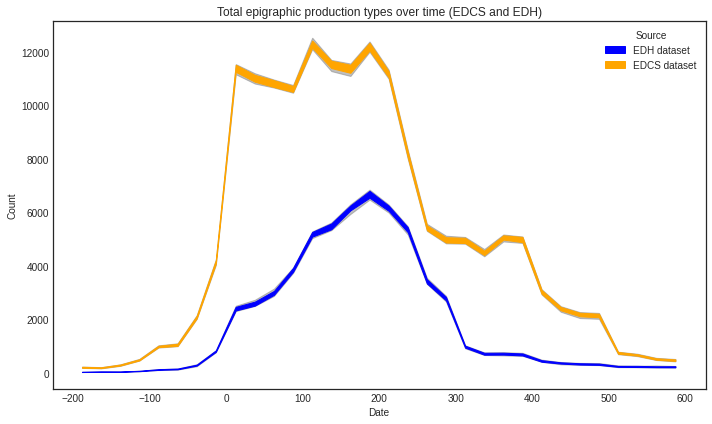

In [59]:
tab_colors_list = list(mcolors.TABLEAU_COLORS.keys())
plt.style.use("seaborn-white")

fig, ax = plt.subplots(figsize=(10, 6), tight_layout=True)

tempun.plot_timeblocks_data(
    EDH_complete_simulations, ax=ax, color="blue", label="EDH dataset")
tempun.plot_timeblocks_data(
    EDCS_complete_simulations, ax=ax, color="orange", label="EDCS dataset")

ax.set_xlabel("Date")
ax.set_ylabel("Count")
ax.set_title("Total epigraphic production types over time (EDCS and EDH)")
ax.legend(title="Source", bbox_to_anchor=(1, 1), loc='upper right')

#### Overlapping inscriptions

In [60]:
# EDCS contains "Links" column, containing reference to EDH
links_with_edh = EDCS[EDCS["Links"].str.contains(
    "edh", na=False)]["Links"].tolist()
edh_ids = [link.rpartition("edh/inschrift/")[2].split()[0]
           for link in links_with_edh]
len(edh_ids)

74304

In [61]:
EDCSstrip = EDCS[~EDCS["Links"].str.contains("edh", na=False)]
len(EDCSstrip)

426314

In [62]:
# EDCSstripstrip dataset
EDCSstrip["start_yr"] = pd.to_numeric(EDCSstrip["start_yr"])
EDCSstrip["end_yr_1"] = pd.to_numeric(EDCSstrip["end_yr_1"])

# how many of the inscriptions have at least one date
EDCSstrip_dated = EDCSstrip[(EDCSstrip["start_yr"].notnull()) | (
    EDCSstrip["end_yr_1"].notnull())]
len(EDCSstrip_dated)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


106382

In [63]:
% % time
# Generate a list of 1000 random dates for each inscription in the dataset
EDCSstrip_dated["random_dates"] = EDCSstrip_dated.apply(
    lambda row: tempun.model_date(row["start_yr"], row["end_yr_1"], size=1000,), axis=1)

CPU times: user 1min 12s, sys: 1min 2s, total: 2min 15s
Wall time: 3min 1s


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [64]:
% % time
# Count random dates in temporal bins (timeblocks) in a specified time range
EDCSstrip_complete_simulations = tempun.timeblocks_from_randoms(
    EDCSstrip_dated, "random_dates", [-200, 600, 25])

CPU times: user 7.8 s, sys: 739 ms, total: 8.54 s
Wall time: 8.98 s


In [ ]:
tab_colors_list = list(mcolors.TABLEAU_COLORS.keys())
plt.style.use("seaborn-white")

fig, ax = plt.subplots(figsize=(10, 6), tight_layout=True)

tempun.plot_timeblocks_data(
    EDH_complete_simulations, ax=ax, color="blue", label="EDH dataset")
tempun.plot_timeblocks_data(
    EDCS_complete_simulations, ax=ax, color="orange", label="EDCS dataset")
tempun.plot_timeblocks_data(
    EDCSstrip_complete_simulations, ax=ax, color="red", label="EDCS without EDH")

ax.set_xlabel("Date")
ax.set_ylabel("Count")
ax.set_title("Total epigraphic production over time (EDCS and EDH compared)")
ax.legend(title="Source", bbox_to_anchor=(1, 1), loc='upper right')

### Function of inscriptions over time

In [66]:
% % time
# Inscriptions by type over time

simulations_by_type_len_EDH = []

for ins_type in EDH["type_of_inscription_clean"].unique():
    if ins_type != "NULL":
        subset_df = EDH_dated[EDH_dated["type_of_inscription_clean"] == ins_type]
        simulations_by_type_len_EDH.append((ins_type, len(subset_df)))
simulations_by_type_len_EDH = sorted(
    simulations_by_type_len_EDH, key=lambda x: x[1], reverse=True)
simulations_by_type_len_EDH

simulations_by_type_EDH = []

for ins_type_tup in simulations_by_type_len_EDH[:10]:
    subset_df = EDH_dated[EDH_dated["type_of_inscription_clean"]
                          == ins_type_tup[0]]
    simulations = tempun.timeblocks_from_randoms(
        subset_df, "random_dates", [-200, 600, 25])
    ins_type_N = len(subset_df)
    simulations_by_type_EDH.append([ins_type_tup[0], ins_type_N, simulations])
simulations_by_type_EDH = sorted(
    simulations_by_type_EDH, key=lambda x: x[1], reverse=True)

date_vars_by_instypes = []
for ins_type_tup in simulations_by_type_len_EDH[:10]:
    subset_df = EDH_dated[EDH_dated["type_of_inscription_clean"]
                          == ins_type_tup[0]]
    date_vars = []
    for n in range(100):
        date_vars.append(
            [date_var[n] for date_var in subset_df["random_dates"] if date_var != None])
    date_vars_by_instypes.append(date_vars)

CPU times: user 7.19 s, sys: 6.14 s, total: 13.3 s
Wall time: 28.7 s


In [67]:
simulations_by_type_len_EDH

[('epitaph', 25516),
 ('votive inscription', 13018),
 ('owner/artist inscription', 4224),
 ('honorific inscription', 3576),
 ('building/dedicatory inscription', 3107),
 ('mile-/leaguestone', 1630),
 ('identification inscription', 1377),
 ('acclamation', 470),
 ('military diploma', 410),
 ('list', 328),
 ('defixio', 297),
 ('label', 232),
 ('boundary inscription', 203),
 ('public legal inscription', 182),
 ('elogium', 138),
 ('letter', 121),
 ('seat inscription', 66),
 ('prayer', 50),
 ('private legal inscription', 43),
 ('assignation inscription', 16),
 ('calendar', 11),
 ('adnuntiatio', 3)]

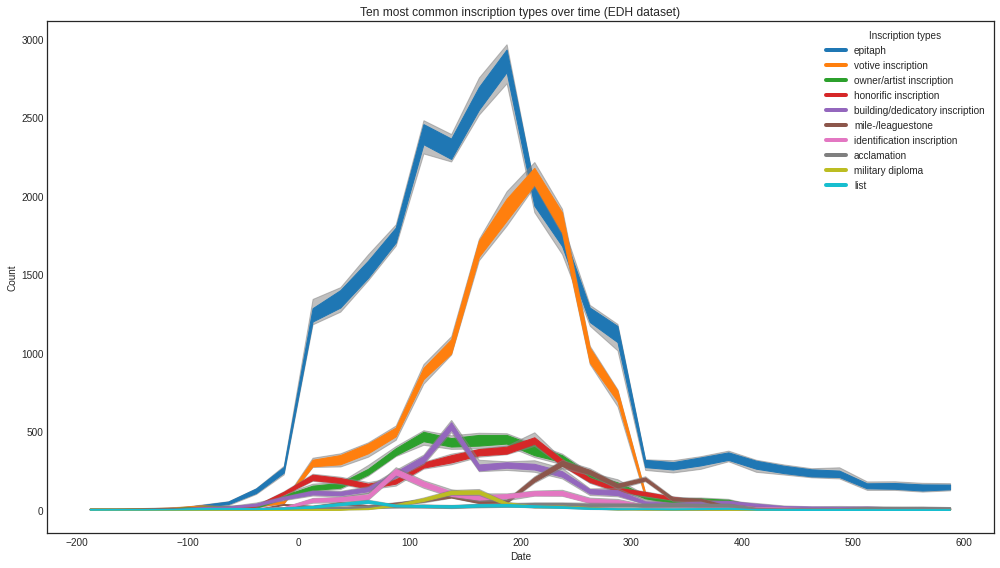

In [68]:
tab_colors_list = list(mcolors.TABLEAU_COLORS.keys())
plt.style.use("seaborn-white")

fig, ax = plt.subplots(figsize=(14, 8), tight_layout=True)

for ins_type_sims, color in zip(simulations_by_type_EDH, tab_colors_list[:len(simulations_by_type_EDH)]):
    tempun.plot_timeblocks_data(ins_type_sims[2], ax=ax, color=color)

ax.set_xlabel("Date")
ax.set_ylabel("Count")
ax.set_title("Ten most common inscription types over time (EDH dataset)")

markers = [plt.Line2D([0, 0], [0, 0], color=color, lw=4)
           for color in tab_colors_list[:len(simulations_by_type_EDH)]]
plt.legend(markers, [tup[0] for tup in simulations_by_type_EDH], numpoints=1,
           title="Inscription types", bbox_to_anchor=(1, 1), loc='upper right')

In [69]:
# Function to transform all inscription types into list form (originally it contains a lot of empty dictionaries etc.)
def clean_inscr_type(el):
    if isinstance(el, str):
        return [el]
    elif isinstance(el, dict):
        return []
    else:
        return el


EDCS_dated["inscr_type_list"] = EDCS_dated["inscr_type"].apply(
    clean_inscr_type)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [70]:
inscr_types_flatlist = [
    el for ellist in EDCS_dated["inscr_type_list"].tolist() for el in ellist]
simulations_by_type_len_EDCS = list(
    nltk.FreqDist(inscr_types_flatlist).most_common())
simulations_by_type_len_EDCS

[('tituli sepulcrales', 82653),
 ('inscriptiones christianae', 27143),
 ('tituli sacri', 20194),
 ('tituli fabricationis', 9381),
 ('tituli operum', 8681),
 ('tituli possessionis', 5845),
 ('tituli honorarii', 5742),
 ('miliaria', 3842),
 ('carmina', 1891),
 ('diplomata militaria', 1033),
 ('leges', 621),
 ('termini', 531),
 ('defixiones', 409),
 ('signacula', 303),
 ('reges', 104),
 ('senatus consulta', 22)]

In [71]:
% % time
# Inscriptions by type over time

simulations_by_type_EDCS = []

for ins_type_tup in simulations_by_type_len_EDCS[:10]:
    subset_df = EDCS_dated[EDCS_dated["inscr_type_list"].apply(
        lambda x: ins_type_tup[0] in x)]
    simulations = tempun.timeblocks_from_randoms(
        subset_df, "random_dates", [-200, 600, 25])
    ins_type_N = len(subset_df)
    simulations_by_type_EDCS.append([ins_type_tup[0], ins_type_N, simulations])

date_vars_by_instypes = []
for ins_type_tup in simulations_by_type_len_EDCS[:10]:
    subset_df = EDCS_dated[EDCS_dated["inscr_type_list"].apply(
        lambda x: ins_type_tup[0] in x)]
    date_vars = []
    for n in range(100):
        date_vars.append(
            [date_var[n] for date_var in subset_df["random_dates"] if date_var != None])
    date_vars_by_instypes.append(date_vars)

CPU times: user 17.4 s, sys: 2.58 s, total: 20 s
Wall time: 23.9 s


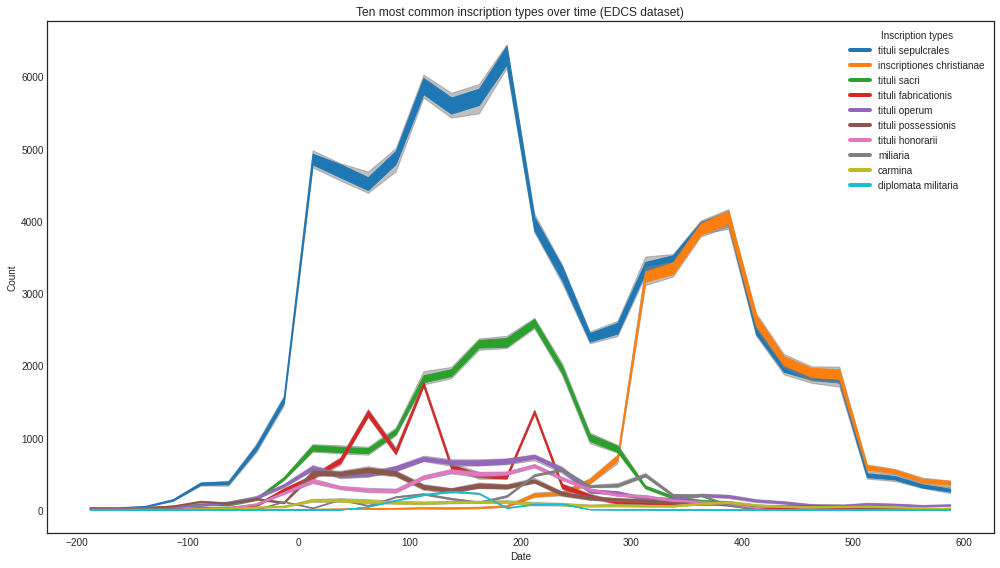

In [72]:
# Plot of EDCS only

tab_colors_list = list(mcolors.TABLEAU_COLORS.keys())
plt.style.use("seaborn-white")

fig, ax = plt.subplots(figsize=(14, 8), tight_layout=True)

for ins_type_sims, color in zip(simulations_by_type_EDCS, tab_colors_list[:len(simulations_by_type_EDCS)]):
    tempun.plot_timeblocks_data(ins_type_sims[2], ax=ax, color=color)

ax.set_xlabel("Date")
ax.set_ylabel("Count")
ax.set_title("Ten most common inscription types over time (EDCS dataset)")

markers = [plt.Line2D([0, 0], [0, 0], color=color, lw=4)
           for color in tab_colors_list[:len(simulations_by_type_EDCS)]]
plt.legend(markers, [tup[0] for tup in simulations_by_type_EDCS], numpoints=1,
           title="Inscription types", bbox_to_anchor=(1, 1), loc='upper right')

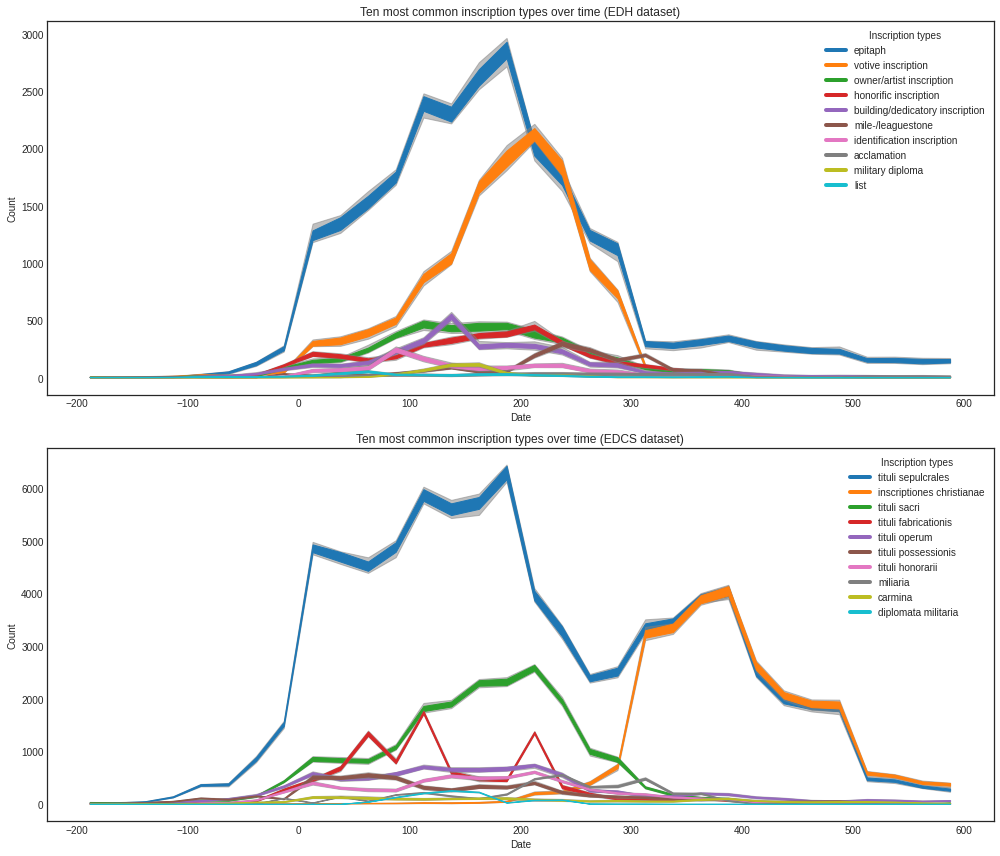

In [73]:
# Plot combining EDH and EDCS
tab_colors_list = list(mcolors.TABLEAU_COLORS.keys())
plt.style.use("seaborn-white")

fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(14, 12), tight_layout=True)

for ins_type_sims, color in zip(simulations_by_type_EDH, tab_colors_list[:len(simulations_by_type_EDH)]):
    tempun.plot_timeblocks_data(ins_type_sims[2], ax=ax1, color=color)

ax1.set_xlabel("Date")
ax1.set_ylabel("Count")
ax1.set_title("Ten most common inscription types over time (EDH dataset)")

markers = [plt.Line2D([0, 0], [0, 0], color=color, lw=4)
           for color in tab_colors_list[:len(simulations_by_type_EDH)]]
ax1.legend(markers, [tup[0] for tup in simulations_by_type_EDH], numpoints=1,
           title="Inscription types", bbox_to_anchor=(1, 1), loc='upper right')

for ins_type_sims, color in zip(simulations_by_type_EDCS, tab_colors_list[:len(simulations_by_type_EDCS)]):
    tempun.plot_timeblocks_data(ins_type_sims[2], ax=ax2, color=color)

ax2.set_xlabel("Date")
ax2.set_ylabel("Count")
ax2.set_title("Ten most common inscription types over time (EDCS dataset)")

markers = [plt.Line2D([0, 0], [0, 0], color=color, lw=4)
           for color in tab_colors_list[:len(simulations_by_type_EDCS)]]
ax2.legend(markers, [tup[0] for tup in simulations_by_type_EDCS], numpoints=1,
           title="Inscription types", bbox_to_anchor=(1, 1), loc='upper right')

#### EDCS without EDH

In [84]:
# Function to transform all inscription types into list form (originally it contains a lot of empty dictionaries etc.)
def clean_inscr_type(el):
    if isinstance(el, str):
        return [el]
    elif isinstance(el, dict):
        return []
    else:
        return el


EDCSstrip_dated["inscr_type_list_flat"] = EDCSstrip_dated["inscr_type"].apply(
    clean_inscr_type)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [85]:
inscr_types_flatlist_EDCSstrip = [
    el for ellist in EDCSstrip_dated["inscr_type_list_flat"].tolist() for el in ellist]
simulations_by_type_len_EDCSstrip = list(
    nltk.FreqDist(inscr_types_flatlist_EDCSstrip).most_common())
simulations_by_type_len_EDCSstrip

[('tituli sepulcrales', 59490),
 ('inscriptiones christianae', 24274),
 ('tituli sacri', 7184),
 ('tituli fabricationis', 7032),
 ('tituli operum', 4545),
 ('tituli possessionis', 4188),
 ('tituli honorarii', 2928),
 ('miliaria', 2171),
 ('carmina', 1278),
 ('diplomata militaria', 559),
 ('leges', 399),
 ('termini', 350),
 ('signacula', 265),
 ('defixiones', 151),
 ('reges', 55),
 ('senatus consulta', 13)]

In [88]:
% % time
# Inscriptions by type over time

simulations_by_type_EDCSstrip = []

for ins_type_tup in simulations_by_type_len_EDCSstrip[:10]:
    subset_df = EDCSstrip_dated[EDCSstrip_dated["inscr_type_list_flat"].apply(
        lambda x: ins_type_tup[0] in x)]
    simulations = tempun.timeblocks_from_randoms(
        subset_df, "random_dates", [-200, 600, 25])
    ins_type_N = len(subset_df)
    simulations_by_type_EDCSstrip.append(
        [ins_type_tup[0], ins_type_N, simulations])

date_vars_by_instypes = []
for ins_type_tup in simulations_by_type_len_EDCSstrip[:10]:
    subset_df = EDCSstrip_dated[EDCSstrip_dated["inscr_type_list_flat"].apply(
        lambda x: ins_type_tup[0] in x)]
    date_vars = []
    for n in range(100):
        date_vars.append(
            [date_var[n] for date_var in subset_df["random_dates"] if date_var != None])
    date_vars_by_instypes.append(date_vars)

CPU times: user 11.5 s, sys: 2.52 s, total: 14 s
Wall time: 16.2 s


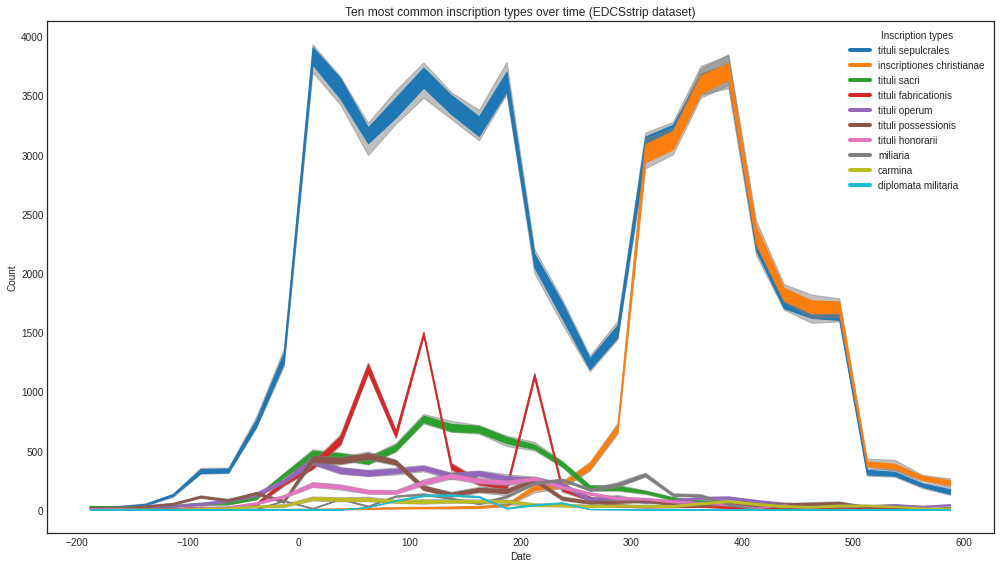

In [89]:
# Plot of EDCSstrip only

tab_colors_list = list(mcolors.TABLEAU_COLORS.keys())
plt.style.use("seaborn-white")

fig, ax = plt.subplots(figsize=(14, 8), tight_layout=True)

for ins_type_sims, color in zip(simulations_by_type_EDCSstrip, tab_colors_list[:len(simulations_by_type_EDCSstrip)]):
    tempun.plot_timeblocks_data(ins_type_sims[2], ax=ax, color=color)

ax.set_xlabel("Date")
ax.set_ylabel("Count")
ax.set_title("Ten most common inscription types over time (EDCSstrip dataset)")

markers = [plt.Line2D([0, 0], [0, 0], color=color, lw=4)
           for color in tab_colors_list[:len(simulations_by_type_EDCSstrip)]]
plt.legend(markers, [tup[0] for tup in simulations_by_type_EDCSstrip], numpoints=1,
           title="Inscription types", bbox_to_anchor=(1, 1), loc='upper right')

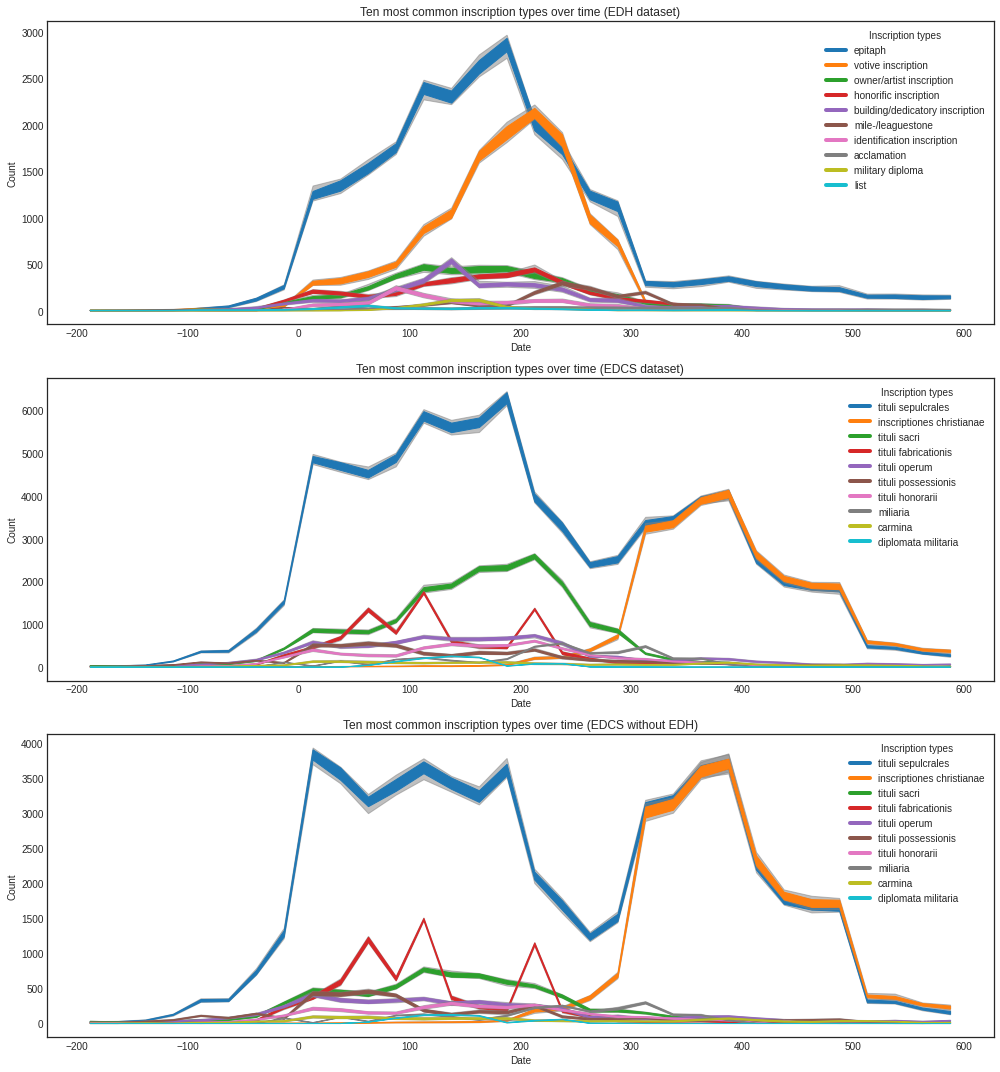

In [92]:
# Plot combining EDH and EDCS
tab_colors_list = list(mcolors.TABLEAU_COLORS.keys())
plt.style.use("seaborn-white")

fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(14, 15), tight_layout=True)

for ins_type_sims, color in zip(simulations_by_type_EDH, tab_colors_list[:len(simulations_by_type_EDH)]):
    tempun.plot_timeblocks_data(ins_type_sims[2], ax=ax1, color=color)

ax1.set_xlabel("Date")
ax1.set_ylabel("Count")
ax1.set_title("Ten most common inscription types over time (EDH dataset)")

markers = [plt.Line2D([0, 0], [0, 0], color=color, lw=4)
           for color in tab_colors_list[:len(simulations_by_type_EDH)]]
ax1.legend(markers, [tup[0] for tup in simulations_by_type_EDH], numpoints=1,
           title="Inscription types", bbox_to_anchor=(1, 1), loc='upper right')

for ins_type_sims, color in zip(simulations_by_type_EDCS, tab_colors_list[:len(simulations_by_type_EDCS)]):
    tempun.plot_timeblocks_data(ins_type_sims[2], ax=ax2, color=color)

ax2.set_xlabel("Date")
ax2.set_ylabel("Count")
ax2.set_title("Ten most common inscription types over time (EDCS dataset)")

markers = [plt.Line2D([0, 0], [0, 0], color=color, lw=4)
           for color in tab_colors_list[:len(simulations_by_type_EDCS)]]
ax2.legend(markers, [tup[0] for tup in simulations_by_type_EDCS], numpoints=1,
           title="Inscription types", bbox_to_anchor=(1, 1), loc='upper right')

for ins_type_sims, color in zip(simulations_by_type_EDCSstrip, tab_colors_list[:len(simulations_by_type_EDCSstrip)]):
    tempun.plot_timeblocks_data(ins_type_sims[2], ax=ax3, color=color)

ax3.set_xlabel("Date")
ax3.set_ylabel("Count")
ax3.set_title("Ten most common inscription types over time (EDCS without EDH)")

markers = [plt.Line2D([0, 0], [0, 0], color=color, lw=4)
           for color in tab_colors_list[:len(simulations_by_type_EDCSstrip)]]
plt.legend(markers, [tup[0] for tup in simulations_by_type_EDCSstrip], numpoints=1,
           title="Inscription types", bbox_to_anchor=(1, 1), loc='upper right')

### Spatio-temporal distribution of inscriptions by Provinces

In [93]:
% % time
# Inscriptions by type over time

simulations_by_prov_len_EDH = []

for ins_type in EDH["province_label_clean"].unique():
    if ins_type != "NULL":
        subset_df = EDH_dated[EDH_dated["province_label_clean"] == ins_type]
        simulations_by_prov_len_EDH.append((ins_type, len(subset_df)))
simulations_by_prov_len_EDH = sorted(
    simulations_by_prov_len_EDH, key=lambda x: x[1], reverse=True)
simulations_by_prov_len_EDH

simulations_by_prov_EDH = []

for ins_type_tup in simulations_by_prov_len_EDH[:10]:
    subset_df = EDH_dated[EDH_dated["province_label"] == ins_type_tup[0]]
    simulations = tempun.timeblocks_from_randoms(
        subset_df, "random_dates", [-200, 600, 25])
    ins_type_N = len(subset_df)
    simulations_by_prov_EDH.append([ins_type_tup[0], ins_type_N, simulations])
simulations_by_prov_EDH = sorted(
    simulations_by_prov_EDH, key=lambda x: x[1], reverse=True)

CPU times: user 4.35 s, sys: 9.74 s, total: 14.1 s
Wall time: 30.7 s


In [94]:
simulations_by_prov_len_EDH[:20]

[('Dalmatia', 7543),
 ('Germania superior', 6559),
 ('Britannia', 4402),
 ('Pannonia superior', 4182),
 ('Dacia', 3485),
 ('Pannonia inferior', 3109),
 ('Germania inferior', 3003),
 ('Noricum', 2726),
 ('Hispania citerior', 2668),
 ('Roma', 2556),
 ('Baetica', 2431),
 ('Moesia inferior', 1849),
 ('Numidia', 1599),
 ('Moesia superior', 1327),
 ('Africa Proconsularis', 1228),
 ('Macedonia', 1088),
 ('Raetia', 976),
 ('Belgica', 970),
 ('Latium et Campania (Regio I)', 820),
 ('Achaia', 636)]

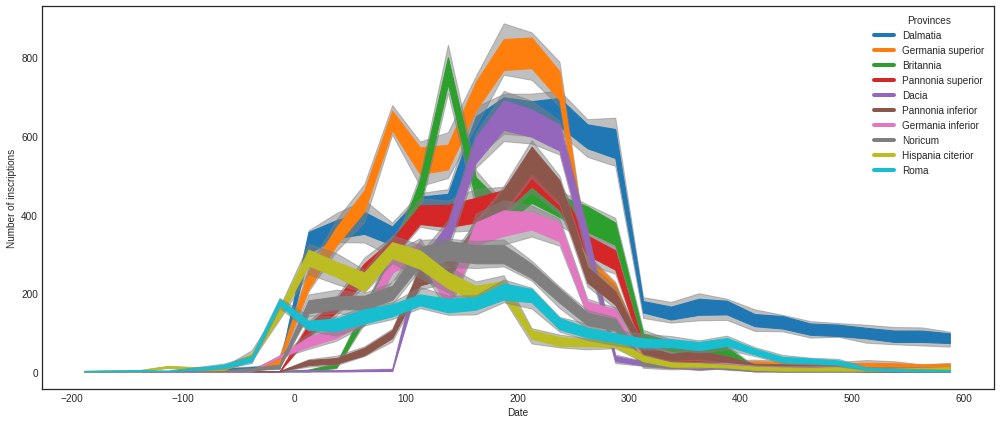

In [128]:
tab_colors_list = list(mcolors.TABLEAU_COLORS.keys())
plt.style.use("seaborn-white")

fig, ax = plt.subplots(figsize=(14, 6), tight_layout=True)

for ins_type_sims, color in zip(simulations_by_prov_EDH, tab_colors_list[:len(simulations_by_prov_EDH)]):
    tempun.plot_timeblocks_data(ins_type_sims[2], ax=ax, color=color)

ax.set_xlabel("Date")
ax.set_ylabel("Number of inscriptions")
#ax.set_title("Ten provinces with most inscriptions over time (EDH dataset)")

markers = [plt.Line2D([0, 0], [0, 0], color=color, lw=4)
           for color in tab_colors_list[:len(simulations_by_prov_EDH)]]

plt.legend(markers, [tup[0] for tup in simulations_by_prov_EDH], numpoints=1,
           title="Provinces", bbox_to_anchor=(1, 1), loc='upper right')

plt.savefig('Epigraphic_production_provinces_EDH.png')

In [96]:
# Function to transform all inscription types into list form (originally it contains a lot of empty dictionaries etc.)
def clean_province(el):
    if isinstance(el, str):
        return [el]
    elif isinstance(el, dict):
        return []
    else:
        return el


EDCS_dated["province"] = EDCS_dated["province"].apply(clean_province)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [97]:
provinces_flatlist = [el for ellist in EDCS_dated["province"].tolist()
                      for el in ellist]
simulations_by_prov_len_EDCS = list(
    nltk.FreqDist(provinces_flatlist).most_common())
simulations_by_prov_len_EDCS[:20]

[('Roma', 46695),
 ('Latium et Campania / Regio I', 17852),
 ('Dalmatia', 7687),
 ('Hispania citerior', 6358),
 ('Venetia et Histria / Regio X', 6019),
 ('Germania superior', 5046),
 ('Dacia', 5008),
 ('Pannonia superior', 4628),
 ('Britannia', 3963),
 ('Samnium / Regio IV', 3703),
 ('Etruria / Regio VII', 3512),
 ('Africa proconsularis', 3460),
 ('Apulia et Calabria / Regio II', 3456),
 ('Pannonia inferior', 3217),
 ('Numidia', 3145),
 ('Baetica', 2866),
 ('Umbria / Regio VI', 2846),
 ('Noricum', 2768),
 ('Transpadana / Regio XI', 2678),
 ('Moesia inferior', 2582)]

In [98]:
% % time
# Inscriptions by Province over time

simulations_by_prov_EDCS = []

for ins_type_tup in simulations_by_prov_len_EDCS[:10]:
    subset_df = EDCS_dated[EDCS_dated["province"].apply(
        lambda x: ins_type_tup[0] in x)]
    simulations = tempun.timeblocks_from_randoms(
        subset_df, "random_dates", [-200, 600, 25])
    ins_type_N = len(subset_df)
    simulations_by_prov_EDCS.append([ins_type_tup[0], ins_type_N, simulations])
#simulations_by_prov_EDCS = sorted(simulations_by_prov_EDCS, key=lambda x: x[1], reverse=True)


date_vars_by_instypes = []
for ins_type_tup in simulations_by_prov_len_EDCS[:10]:
    subset_df = EDCS_dated[EDCS_dated["province"].apply(
        lambda x: ins_type_tup[0] in x)]
    date_vars = []
    for n in range(100):
        date_vars.append(
            [date_var[n] for date_var in subset_df["random_dates"] if date_var != None])
    date_vars_by_instypes.append(date_vars)

CPU times: user 9.25 s, sys: 430 ms, total: 9.68 s
Wall time: 10.6 s


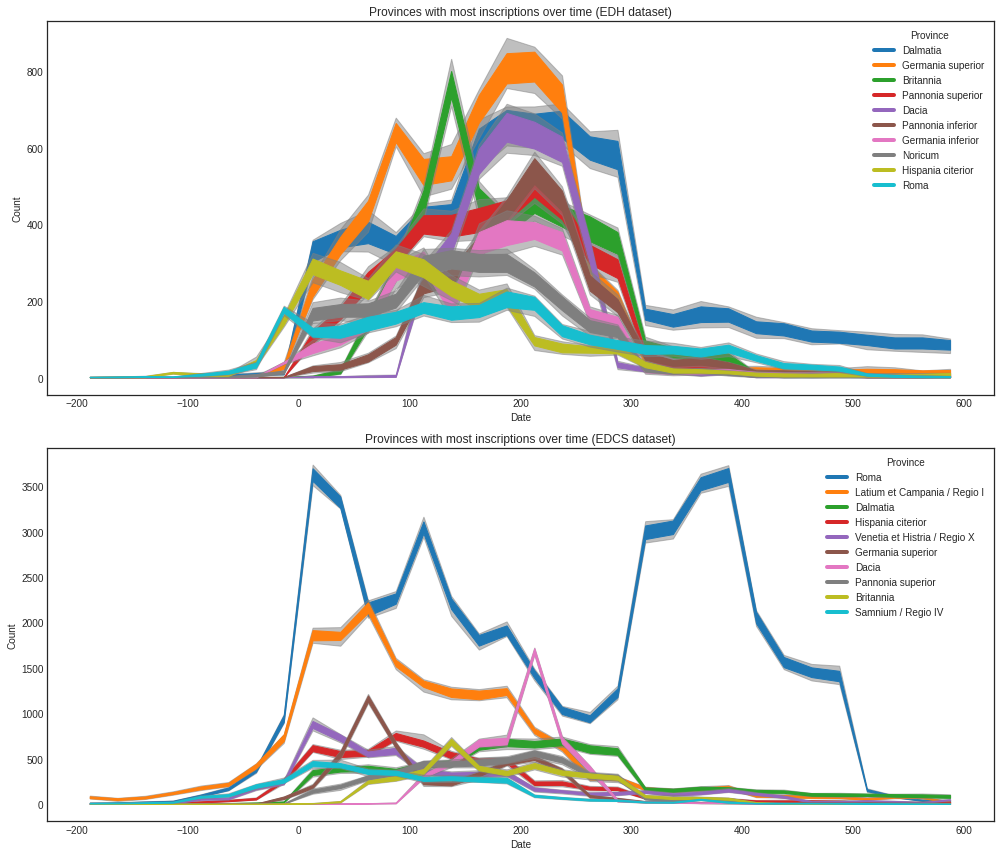

In [110]:
# plot combining EDH and EDCS
tab_colors_list = list(mcolors.TABLEAU_COLORS.keys())
plt.style.use("seaborn-white")

fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(14, 12), tight_layout=True)

for ins_type_sims, color in zip(simulations_by_prov_EDH, tab_colors_list[:len(simulations_by_prov_EDH)]):
    tempun.plot_timeblocks_data(ins_type_sims[2], ax=ax1, color=color)

ax1.set_xlabel("Date")
ax1.set_ylabel("Count")
ax1.set_title("Provinces with most inscriptions over time (EDH dataset)")

markers = [plt.Line2D([0, 0], [0, 0], color=color, lw=4)
           for color in tab_colors_list[:len(simulations_by_prov_EDH)]]
ax1.legend(markers, [tup[0] for tup in simulations_by_prov_EDH],
           numpoints=1,  title="Province", bbox_to_anchor=(1, 1), loc='upper right')

for ins_type_sims, color in zip(simulations_by_prov_EDCS, tab_colors_list[:len(simulations_by_prov_EDCS)]):
    tempun.plot_timeblocks_data(ins_type_sims[2], ax=ax2, color=color)

ax2.set_xlabel("Date")
ax2.set_ylabel("Count")
ax2.set_title("Provinces with most inscriptions over time (EDCS dataset)")

markers = [plt.Line2D([0, 0], [0, 0], color=color, lw=4)
           for color in tab_colors_list[:len(simulations_by_prov_EDCS)]]
ax2.legend(markers, [tup[0] for tup in simulations_by_prov_EDCS],
           numpoints=1,  title="Province", bbox_to_anchor=(1, 1), loc='upper right')

#### EDCS without EDH

In [101]:
EDCSstrip_dated["province"] = EDCSstrip_dated["province"].apply(clean_province)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [102]:
provinces_flatlist_EDCSstrip = [
    el for ellist in EDCSstrip_dated["province"].tolist() for el in ellist]
simulations_by_prov_len_EDCSstrip = list(
    nltk.FreqDist(provinces_flatlist_EDCSstrip).most_common())
simulations_by_prov_len_EDCSstrip[:20]

[('Roma', 43392),
 ('Latium et Campania / Regio I', 15894),
 ('Venetia et Histria / Regio X', 5088),
 ('Hispania citerior', 3213),
 ('Samnium / Regio IV', 3167),
 ('Apulia et Calabria / Regio II', 2750),
 ('Etruria / Regio VII', 2724),
 ('Transpadana / Regio XI', 2519),
 ('Umbria / Regio VI', 2497),
 ('Germania superior', 2424),
 ('Africa proconsularis', 1997),
 ('Sicilia', 1913),
 ('Dacia', 1476),
 ('Numidia', 1406),
 ('Sardinia', 1068),
 ('Picenum / Regio V', 1035),
 ('Lusitania', 960),
 ('Liguria / Regio IX', 942),
 ('Aemilia / Regio VIII', 915),
 ('Belgica', 904)]

In [103]:
% % time
# Inscriptions by Province over time

simulations_by_prov_EDCSstrip = []

for ins_type_tup in simulations_by_prov_len_EDCSstrip[:10]:
    subset_df = EDCSstrip_dated[EDCSstrip_dated["province"].apply(
        lambda x: ins_type_tup[0] in x)]
    simulations = tempun.timeblocks_from_randoms(
        subset_df, "random_dates", [-200, 600, 25])
    ins_type_N = len(subset_df)
    simulations_by_prov_EDCSstrip.append(
        [ins_type_tup[0], ins_type_N, simulations])

date_vars_by_instypes = []
for ins_type_tup in simulations_by_prov_len_EDCSstrip[:10]:
    subset_df = EDCSstrip_dated[EDCSstrip_dated["province"].apply(
        lambda x: ins_type_tup[0] in x)]
    date_vars = []
    for n in range(100):
        date_vars.append(
            [date_var[n] for date_var in subset_df["random_dates"] if date_var != None])
    date_vars_by_instypes.append(date_vars)

CPU times: user 7.05 s, sys: 283 ms, total: 7.33 s
Wall time: 7.33 s


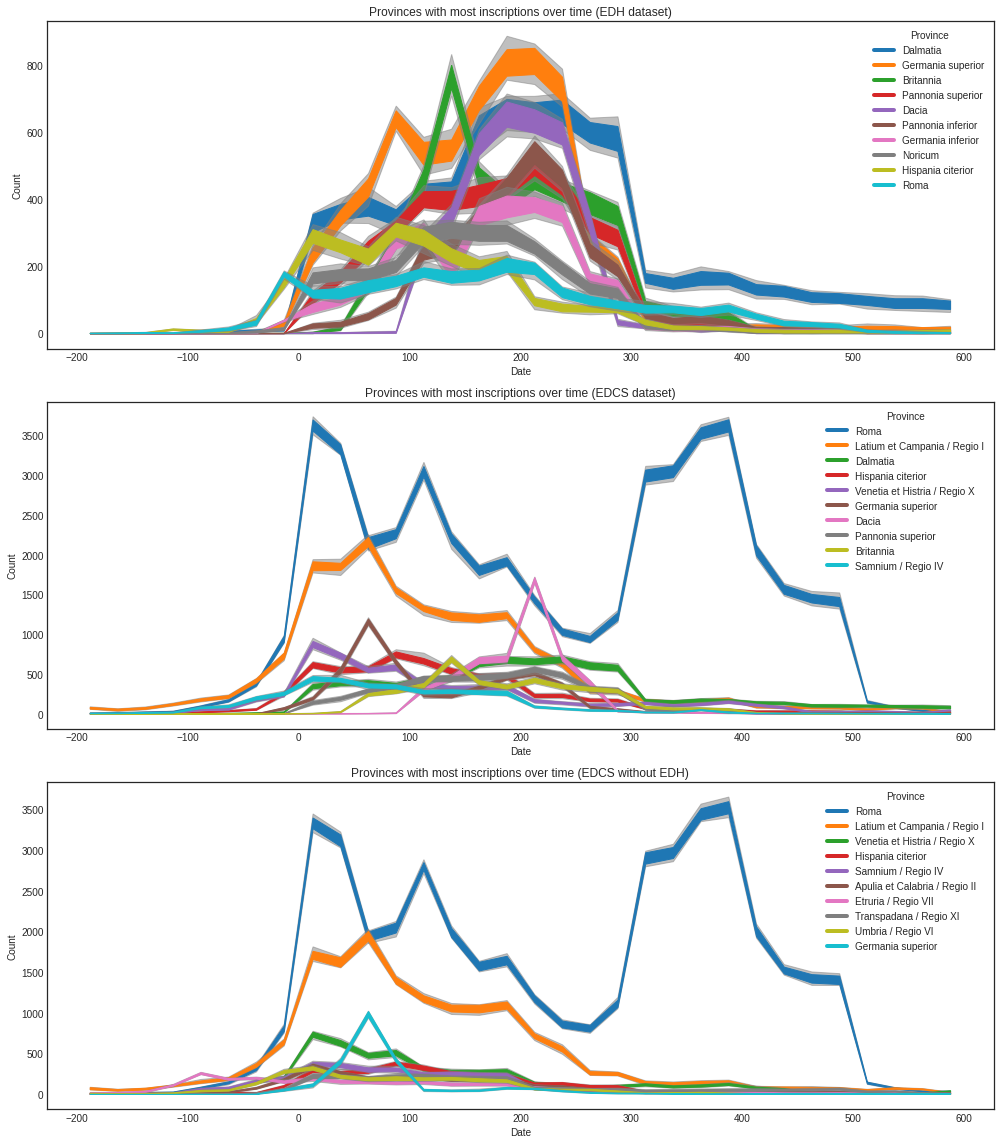

In [107]:
# plot combining EDH and EDCS ans EDCSstrip
tab_colors_list = list(mcolors.TABLEAU_COLORS.keys())
plt.style.use("seaborn-white")

fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(14, 16), tight_layout=True)

for ins_type_sims, color in zip(simulations_by_prov_EDH, tab_colors_list[:len(simulations_by_prov_EDH)]):
    tempun.plot_timeblocks_data(ins_type_sims[2], ax=ax1, color=color)

ax1.set_xlabel("Date")
ax1.set_ylabel("Count")
ax1.set_title("Provinces with most inscriptions over time (EDH dataset)")

markers = [plt.Line2D([0, 0], [0, 0], color=color, lw=4)
           for color in tab_colors_list[:len(simulations_by_prov_EDH)]]
ax1.legend(markers, [tup[0] for tup in simulations_by_prov_EDH],
           numpoints=1,  title="Province", bbox_to_anchor=(1, 1), loc='upper right')

for ins_type_sims, color in zip(simulations_by_prov_EDCS, tab_colors_list[:len(simulations_by_prov_EDCS)]):
    tempun.plot_timeblocks_data(ins_type_sims[2], ax=ax2, color=color)

ax2.set_xlabel("Date")
ax2.set_ylabel("Count")
ax2.set_title("Provinces with most inscriptions over time (EDCS dataset)")

markers = [plt.Line2D([0, 0], [0, 0], color=color, lw=4)
           for color in tab_colors_list[:len(simulations_by_prov_EDCS)]]
ax2.legend(markers, [tup[0] for tup in simulations_by_prov_EDCS],
           numpoints=1,  title="Province", bbox_to_anchor=(1, 1), loc='upper right')

for ins_type_sims, color in zip(simulations_by_prov_EDCSstrip, tab_colors_list[:len(simulations_by_prov_EDCSstrip)]):
    tempun.plot_timeblocks_data(ins_type_sims[2], ax=ax3, color=color)

ax3.set_xlabel("Date")
ax3.set_ylabel("Count")
ax3.set_title("Provinces with most inscriptions over time (EDCS without EDH)")

markers = [plt.Line2D([0, 0], [0, 0], color=color, lw=4)
           for color in tab_colors_list[:len(simulations_by_prov_EDCSstrip)]]
ax3.legend(markers, [tup[0] for tup in simulations_by_prov_EDCSstrip],
           numpoints=1,  title="Province", bbox_to_anchor=(1, 1), loc='upper right')

plt.savefig('Epigraphic_production_provinces.png')

### Inscriptions plotted over centuries in a map

In [11]:
def get_date_var(randoms):
    try:
        return randoms[0]
    except:
        return None


EDCS_dated["date_var_1"] = EDCS_dated["random_dates"].apply(get_date_var)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [12]:
def date_to_str(date):
    if date < 0:
        date = str(abs(date)) + "BC"
    else:
        date = str(date) + "AD"
    return date


periods_labels = []
for period in periods.keys():
    start = date_to_str(periods[period]["startdate"])
    end = date_to_str(periods[period]["enddate"])
    periods_labels.append(period + " ({0}-{1})".format(start, end))
periods_labels

2         [-68, -68, -68, -68, -68, -68, -68, -68, -68, ...
3         [312, 310, 313, 312, 310, 311, 311, 310, 313, ...
9         [241, 198, 245, 246, 202, 207, 250, 207, 236, ...
10        [-74, -74, -74, -74, -74, -74, -74, -74, -74, ...
13        [67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 6...
                                ...                        
500612    [26, 53, 10, 115, 77, 2, 87, 137, 171, 23, 89,...
500613    [75, 159, 142, 56, 81, 22, 168, 149, 157, 199,...
500614    [1, -24, 24, 24, -21, -13, 19, -11, 18, 10, 13...
500615    [342, 398, 347, 336, 358, 373, 305, 336, 364, ...
500616    [360, 352, 352, 414, 352, 424, 420, 405, 414, ...
Name: random_dates, Length: 164452, dtype: object

In [32]:
# periods definitions

periods = {  # to avoid overlaps, startdates are postponed by one year, when needed
    "Late Roman Republic": {"startdate": -200, "enddate": -26},
    "Julio-Claudian": {"startdate": -27, "enddate": 68},
    "Flavian": {"startdate": 69, "enddate": 96},
    "Nerva-Antonine": {"startdate": 97, "enddate": 192},
    "Severan": {"startdate": 193, "enddate": 235},
    "Barracks emperors": {"startdate": 236, "enddate": 284},
    "Tetrarchy\n& Constantine I": {"startdate": 285, "enddate": 337},
    "Late Roman Empire": {"startdate": 338, "enddate": 600}
}
timeblocks_periods = [(periods[period]["startdate"],
                       periods[period]["enddate"]) for period in periods]
timeblocks_periods

[(-200, -26),
 (-27, 68),
 (69, 96),
 (97, 192),
 (193, 235),
 (236, 284),
 (285, 337),
 (338, 600)]

In [33]:
def date_to_str(date):
    if date < 0:
        date = str(abs(date)) + "BC"
    else:
        date = str(date) + "AD"
    return date


periods_labels = []
for period in periods.keys():
    start = date_to_str(periods[period]["startdate"])
    end = date_to_str(periods[period]["enddate"])
    periods_labels.append(period + " ({0}-{1})".format(start, end))
periods_labels

['Late Roman Republic (200BC-26BC)',
 'Julio-Claudian (27BC-68AD)',
 'Flavian (69AD-96AD)',
 'Nerva-Antonine (97AD-192AD)',
 'Severan (193AD-235AD)',
 'Barracks emperors (236AD-284AD)',
 'Tetrarchy\n& Constantine I (285AD-337AD)',
 'Late Roman Empire (338AD-600AD)']

In [34]:
EDCS_dated_df_by_periods = []

for period in timeblocks_periods:
    EDCS_dated_sample = EDCS_dated[EDCS_dated["date_var_1"].between(
        period[0], period[1])]
    EDCS_dated_df_by_periods.append(EDCS_dated_sample)

In [23]:
pleiades_regions = gpd.read_file('pleiades_regions.geojson', driver='GeoJSON')

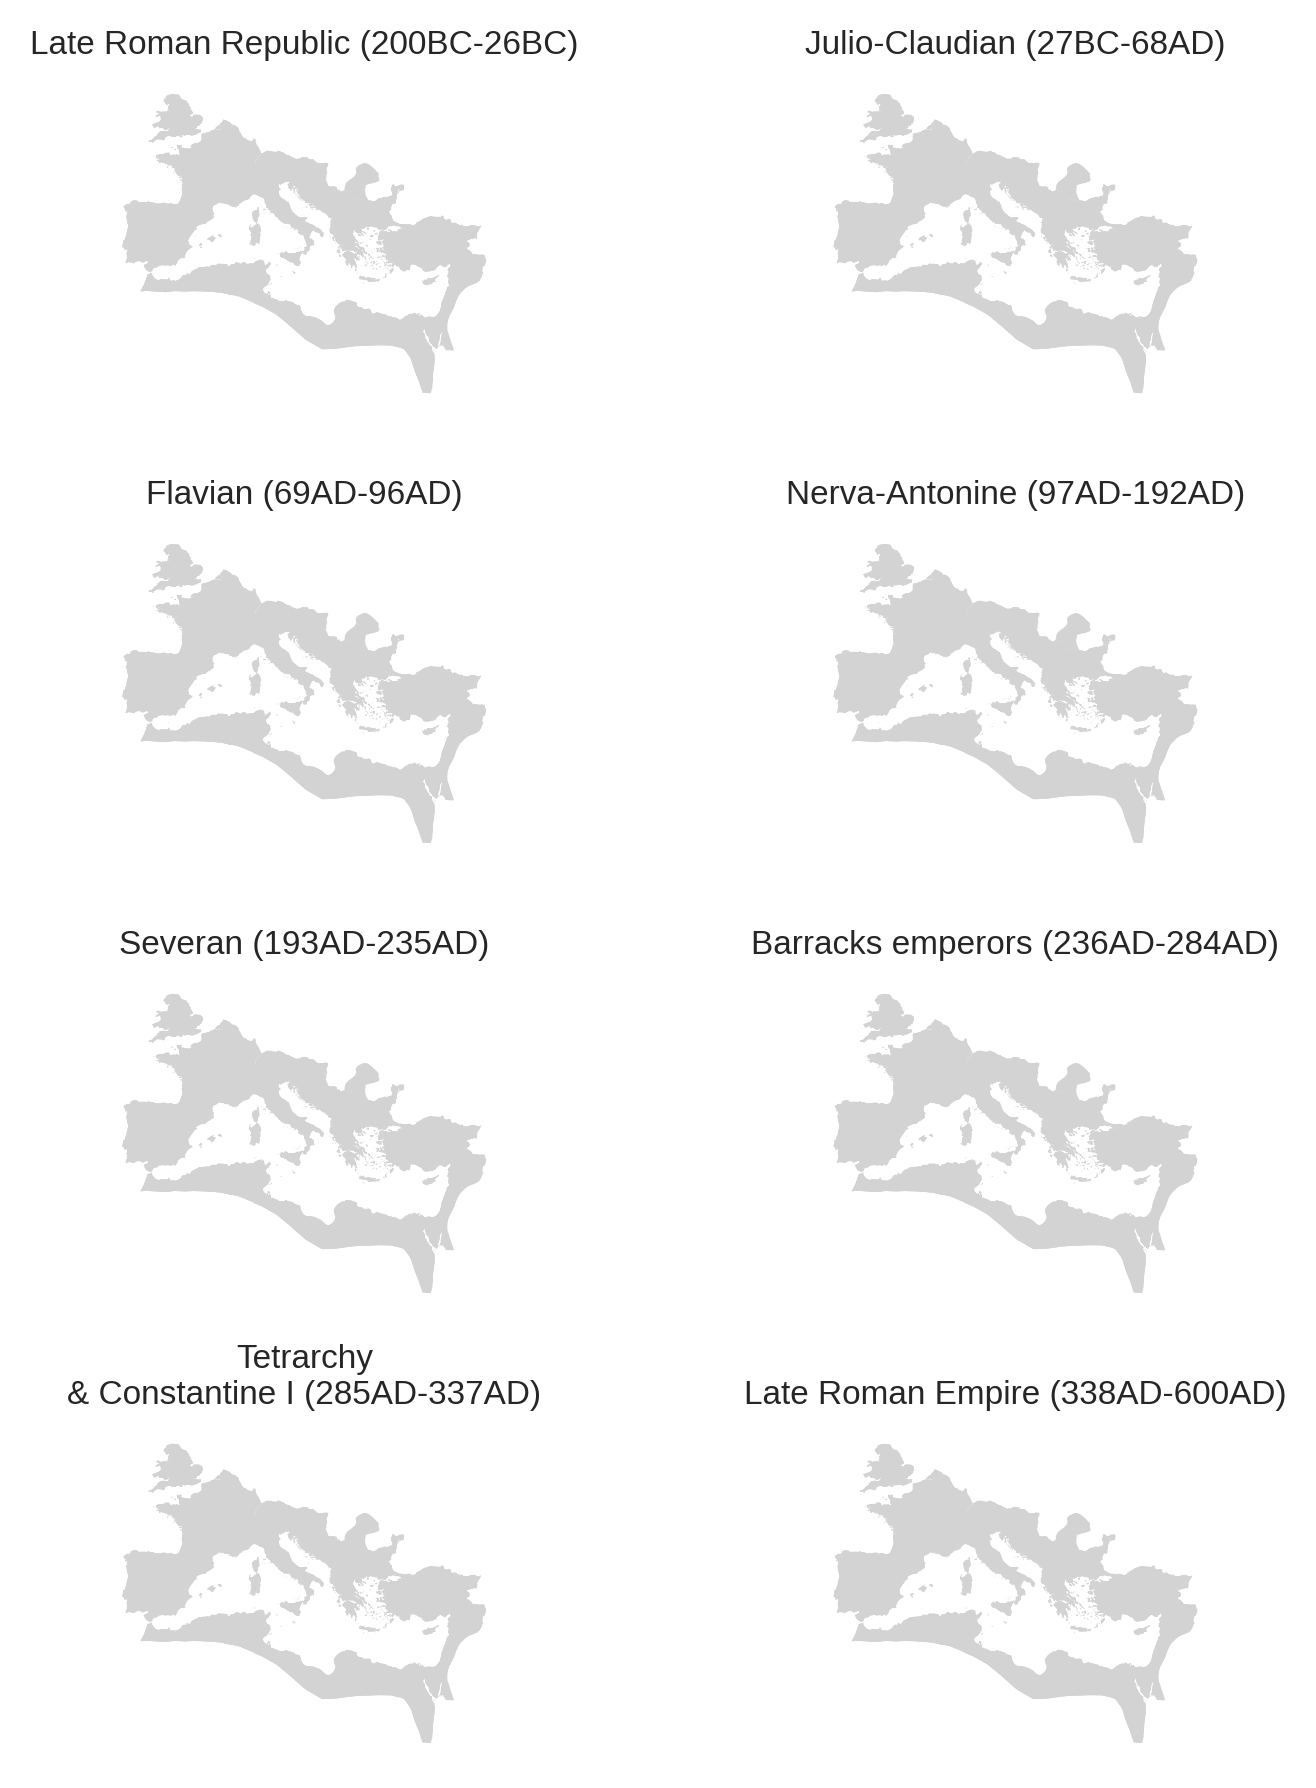

In [49]:
# AIM: all inscriptions with location in 8 plots grouped by period

plt.style.use("seaborn-white")
plt.rcParams['figure.dpi'] = 300
#plt.rcParams["font.family"] = "serif"
plt.rcParams['font.size'] = 8

fig, axs  = plt.subplots(4, 2, figsize=(6, 6), tight_layout=True)

contexts_pct = {}

# original from social_diversity
#for df, ax, period in zip(EDCS_dated_df_by_periods, axs.ravel(), periods_labels):
#    pleiades_regions.plot(ax=ax, color="lightgray")
#    #gplt.kdeplot(df, cmap='Reds', shade=True, thresh=0.05, alpha=0.5, ax=ax)
#    for context, color in [("rest", "orange"), ("middle", "red"), ("big", "darkred")]:
#        df_context = df[df["urban_context"]==context]
#        contexts_pct[context] = str(np.round(((len(df_context) / len(df)) * 100), 2)) + "%"
#        df_context.plot(markersize=0.1, color=color, ax=ax)
#    ax.set_title(period, fontsize=8)
#    ax.set_axis_off()
#    markers = [plt.Line2D([0,0],[0,0],color=color, marker=".", linestyle="") for color in ["darkred", "red", "orange"]]
#    legend_labels = ["Big cities ({0})".format(contexts_pct["big"]), "Middle cities ({0})".format(contexts_pct["middle"]), "Rural areas ({0})".format(contexts_pct["rest"])]
#    ax.legend(markers, legend_labels, numpoints=1, bbox_to_anchor=(0.65, 1.05), loc='upper left', fontsize=6)
    
    
# attempt of a new plot    
for df, ax, period in zip(EDCS_dated_df_by_periods, axs.ravel(), periods_labels):
    pleiades_regions.plot(ax=ax, color="lightgray")
    
#       for context, color in [("rest", "orange"), ("middle", "red"), ("big", "darkred")]:
#        df_context = df[df["urban_context"]==context]
#        contexts_pct[context] = str(np.round(((len(df_context) / len(df)) * 100), 2)) + "%"
#        df_context.plot(markersize=0.1, color=color, ax=ax)
    ax.set_title(period, fontsize=8)
    ax.set_axis_off()
#    markers = [plt.Line2D([0,0],[0,0],color=color, marker=".", linestyle="") for color in ["darkred", "red", "orange"]]
#    legend_labels = ["Big cities ({0})".format(contexts_pct["big"]), "Middle cities ({0})".format(contexts_pct["middle"]), "Rural areas ({0})".format(contexts_pct["rest"])]
#    ax.legend(markers, legend_labels, numpoints=1, bbox_to_anchor=(0.65, 1.05), loc='upper left', fontsize=6)

plt.subplots_adjust(wspace=0, hspace=0)

## Discussion: The epigraphic production in time

As demonstrated above, the 'epigraphic habit' and the curves of epigraphic production highly depend on the choice of source. Both presented datasets have different spatial and temporal coverage and thus they both produce different images of epigraphic activity throughout the Roman Empire in space and time.

Athough the epigraphic community has done a tremendous amount of work standardizing the data by establishing the Epidoc XML format and there has been a great effort put into digitising and publishing resources online, the outcomes of quantitative studies are still relatively limited. Until there is a solution for connecting various epigraphic databases into one LOD source, as proposed by Epigraphy.info community, the outcomes of quantitative research in epigraphy will highely depend on the selection of dataset.

We are hopeful, that in not so distant future, maybe even before 2030, we will be able finally start asking the questions that were bothering epigraphers and historians since the time of MacMullen in 1982. But before that, more effort has to be put into building a sustainable and FAIR solutions, linking the existing datasets and providing paths to digital research.